In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import math
import os
import itertools
import warnings
import glob
import sys

In [2]:
for year in range(1990, 2023):
    page = 1
    while True:
        fName = f"./json_result/mtmtpubs-{year}-{page}.json"
        enYear = year
        stYear = 1900 if year <= 1990 else year
        os.system(f'wget -O {fName} "https://m2.mtmt.hu/api/publication?cond=published;eq;true&cond=core;eq;true&cond=institutes;inia;10856&cond=publishedYear;range;{stYear}%2C{enYear}&sort=publishedYear,desc&sort=firstAuthor,asc&page={page}&size=1000&fields=citations,pubStats&labelLang=hun&cite_type=2"')
        with open(fName, "r") as f:
            try:
                dta = json.load(f)
                if not dta["paging"]["last"]:
                    page += 1
                else:
                    break
            except:
                print("Error, retrying")
                pass



--2023-01-19 13:06:09--  https://m2.mtmt.hu/api/publication?cond=published;eq;true&cond=core;eq;true&cond=institutes;inia;10856&cond=publishedYear;range;1900%2C1990&sort=publishedYear,desc&sort=firstAuthor,asc&page=1&size=1000&fields=citations,pubStats&labelLang=hun&cite_type=2
Resolving m2.mtmt.hu (m2.mtmt.hu)... 193.224.44.74
Connecting to m2.mtmt.hu (m2.mtmt.hu)|193.224.44.74|:443... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [application/vnd.mtmt2-1.0+json]
Saving to: ‘./json_result/mtmtpubs-1990-1.json’

     0K .......... .......... .......... .......... ..........  281K
    50K .......... .......... .......... .......... ..........  650K
   100K .......... .......... .......... .......... ..........  855K
   150K .......... .......... .......... .......... ..........  881K
   200K .......... .......... .......... .......... .......... 1,00M
   250K .......... .......... .......... .......... .......... 1,09M
   300K .......... .......... ........

In [3]:
content = []
for fn in glob.glob("./json_result/mtmtpubs-*.json"):
    pubs = json.load(open(fn))
    content += pubs["content"]

In [4]:
tszmap = {}
#ALGEBRA
#ANALYSIS
#Differential Equations
#Geometry
#Stochastics
tszmap['Algebra Tanszék (BME / TTK / MI)'] = "ALGEBRA"
tszmap['Analízis Tanszék (BME / TTK / MI)'] = "ANALYSIS"
tszmap['Differenciálegyenletek Tanszék (BME / TTK / MI)'] = "Differential_Equations"
tszmap['Geometria Tanszék (BME / TTK / MI)'] = "Geometry"
tszmap['Sztochasztika Tanszék (BME / TTK / MI)'] = "Stochastics"

inst = []
for c in content:
    if "authorships" in c:
        for a in c["authorships"]:
            if a["label"].find("] ") >= 0:
                inst = inst + [tszmap[s] for s in a["label"].split("] ")[-1].split("; ") if s in tszmap]
tanszekek = np.unique(inst)
print(tanszekek)

# Ezek pedig a figyelembe nem vett VIK-es affiliációk
inst = []
for c in content:
    if "authorships" in c:
        for a in c["authorships"]:
            if a["label"].find("] ") >= 0:
                inst = inst + [s for s in a["label"].split("] ")[-1].split("; ") if "BME / TTK / MI)" in s and s not in tszmap]
nemtanszek = np.unique(inst)
print(nemtanszek)

['ALGEBRA' 'ANALYSIS' 'Differential_Equations' 'Geometry' 'Stochastics']
[]


In [5]:
ifdf = pd.read_csv('./pubgraph/ifdf_v8_2021.csv')
ifdf.loc[ifdf["if"].isnull(), "if"] = 0.0
maxIFYear = ifdf.year.max()
ifdf_e = ifdf.copy().set_index(["year", "eissn"]).sort_index()
ifdf_p = ifdf.copy().set_index(["year", "pissn"]).sort_index()

def getif(pub):
    if "journal" not in pub:
        return 0.0, 1.0
    year = min(pub["publishedYear"], maxIFYear)
    if "pIssn" in pub["journal"]:
        issn = pub["journal"]["pIssn"]
        if (year,issn) in ifdf_p.index:
            ifval = ifdf_p.loc[(year,issn),"if"]
            catif = ifdf_p.loc[(year,issn),"categoryMedianIf"]
            if len(ifval) == 1 and float(ifval) > 0.0:
                if len(catif) == 1 and float(catif) > 0.0:
                    return float(ifval), float(catif)
                else:
                    return float(ifval), float(ifval) # ha if-es az újság, de még nem elég régóta. nincs sok ilyen.
    if "eIssn" in pub["journal"]:
        issn = pub["journal"]["eIssn"]
        if (year,issn) in ifdf_e.index:
            ifval = ifdf_e.loc[(year,issn),"if"]
            catif = ifdf_e.loc[(year,issn),"categoryMedianIf"]
            if len(ifval) == 1 and float(ifval) > 0.0:
                if len(catif) == 1 and float(catif) > 0.0:
                    return float(ifval), float(catif)
                else:
                    return float(ifval), float(ifval) # ha if-es az újság, de még nem elég régóta. nincs sok ilyen.
    return 0.0, 1.0

# a függvény visszaadja a folyóirat rangját (D1, Q1, Q2, ...)
def getrating(pub):
    if "ratings" not in pub:
        return ""
    for r in pub["ratings"]:
        if r["otype"] == "SjrRating" and "ranking" in r:
            return r["ranking"]
    return ""


In [6]:
for pub in content:
    pub["mtmt_title"] = ""
    if "error" in pub and pub["error"] != "VALIDATION_ERROR":
        pub["mtmt_cat"] = "skip - error"
    elif not pub["published"]:
        pub["mtmt_cat"] = "skip - nem published"
    elif "category" not in pub or pub["category"]["label"] != "Tudományos":
        pub["mtmt_cat"] = "skip - nem tudományos"        
    elif pub["otype"] == "JournalArticle" and "journal" in pub:
        if pub["fullPublication"] and "reviewType" in pub["journal"] and pub["journal"]["reviewType"] == "REVIEWED" and "subType" in pub and (pub["subType"]["name"] == "Szakcikk" or pub["subType"]["name"] == "Összefoglaló cikk" or pub["subType"]["name"] == "Konferenciaközlemény" or pub["subType"]["name"] == "Rövid közlemény" or pub["subType"]["name"] == "Sokszerzős vagy csoportos szerzőségű szakcikk"):
            pub["mtmt_cat"] = "journal"
        else:
            pub["mtmt_cat"] = "skip - nem lektorált folyóirat vagy nem értékelhető típus"
    elif pub["fullPublication"] and ((pub["type"]["label"] == "Könyvrészlet" and "subType" in pub and pub["subType"]["label"] == "Konferenciaközlemény (Könyvrészlet)") or pub["type"]["label"] == "Egyéb konferenciaközlemény"):
        pub["mtmt_cat"] = "conference"
        if "book" in pub and "title" in pub["book"]:
            pub["mtmt_title"] = pub["book"]["title"]
    elif pub["type"]["label"] == "Könyv" or (pub["type"]["label"] == "Könyvrészlet" and "subType" in pub and (pub["subType"]["label"] == "Könyvfejezet (Könyvrészlet)" or pub["subType"]["label"] == "Szaktanulmány (Könyvrészlet)")):
        pub["mtmt_cat"] = "book"
        if "book" in pub and "title" in pub["book"]:
            pub["mtmt_title"] = pub["title"]
    elif pub["type"]["label"] == "Oltalmi formák":
        pub["mtmt_cat"] = "patent"
    elif not pub["fullPublication"]:
        pub["mtmt_cat"] = "skip - nem full publication"        
    elif pub["type"]["label"] == "Egyéb" or pub["type"]["label"] == "Disszertáció":
        pub["mtmt_cat"] = "skip - other"
    else:
        pub["mtmt_cat"] = "skip - uncategorized"
    
    # Oldalszám - a túl rövid publikációkat az MTA MTO nem veszi figyelembe
    plength = 0
    if 'pageLength' in pub:
        plength = pub["pageLength"]
    elif 'firstPage' in pub and 'lastPage' in pub and pub["lastPage"].isnumeric() and pub["firstPage"].isnumeric():
        plength = int(pub["lastPage"]) - int(pub["firstPage"]) + 1
    
    # Q pontszám kiszámolása a publikációra, az MTA MTO szabályai szerint
    pub["mtmt_q"] = 0    
    pub["mtmt_norm_q"] = 0    
    pub["mtmt_if"] = 0    
    pub["mtmt_norm_if"] = 0    
    nrm = 1.0
    if pub["mtmt_cat"] == "journal":
        ifct, nrm = getif(pub)        
        pub["mtmt_if"] = ifct
        pub["mtmt_norm_if"] = ifct / nrm
        if ifct > 0:
            pub["mtmt_q"] = max(0.6, ifct)
            pub["mtmt_norm_q"] = max(0.6, pub["mtmt_norm_if"])
        else:
            if pub["foreignEdition"]:
                pub["mtmt_q"] = 0.4
            else:
                pub["mtmt_q"] = 0.3
            pub["mtmt_norm_q"] = pub["mtmt_q"]
    elif pub["mtmt_cat"] == "conference" and plength >= 4:
        if pub["foreignLanguage"]:
            pub["mtmt_q"] = 0.2
        else:
            pub["mtmt_q"] = 0.1
        pub["mtmt_norm_q"] = pub["mtmt_q"]
    elif pub["mtmt_cat"] == "book" and plength >= 10:
        if plength >= 100:
            if pub["foreignLanguage"]:
                pub["mtmt_q"] = 2
            else:
                pub["mtmt_q"] = 1
        else:
            if pub["foreignLanguage"]:
                pub["mtmt_q"] = 0.2 * np.floor(plength/10)
            else:
                pub["mtmt_q"] = 0.1 * np.floor(plength/10)            
        pub["mtmt_norm_q"] = pub["mtmt_q"]
    
    # I pontszám kiszámolása, összesen és évenként is
    pub["mtmt_i"] = pub["independentCitationCount"] # teljes eddigi I pontszám
    pub["mtmt_i_year"] = {}
    
    if "pubStats" in pub and "years" in pub["pubStats"]:
        for yr in pub["pubStats"]["years"]:
            pub["mtmt_i_year"][yr["year"]] = yr["independentCitationCount"]
    
    # Tanszék arányok a publikációban
    tszpart = {'ALGEBRA':0, 'ANALYSIS':0, 'Differential_Equations':0, 'Stochastics':0, 'Geometry':0} 
    authors = 0
    if "authorships" in pub:
        for auth in pub["authorships"]:
            if auth["authorTyped"]: # csak szerzőket veszünk figyelembe, szerkesztőket nem!
                authors += 1
                for tsz in tszmap:
                    if tsz in auth["label"]:
                        tszpart[tszmap[tsz]] += 1
                        break
    pub["mtmt_authors"] = authors  # a cikk szerzőinek száma
    if authors > 0:
        for v in tszpart:
            tszpart[v] /= authors
    pub["mtmt_tsz"] = tszpart # a cikkben részt vevő tanszékek aránya
    pub["mtmt_rating"] = getrating(pub)


In [7]:

pubyearly = pd.DataFrame({"Q pontszám": 0.0, 
              "Normalizált Q": 0.0, 
              "I pontszám": 0, 
              "IF": 0.0, 
              "Normalizált IF": 0.0, 
              "Publikációk száma": 0, 
              "Lektorált folyóiratok száma": 0, 
              "Konferenciacikkek száma": 0, 
              "Könyv és könyvfejezet": 0, 
              "Szabadalom": 0, 
              "IF folyóiratok száma": 0, 
              "D1": 0, "Q1": 0, "Q2": 0, "Q3": 0, "Q4": 0
             }, index=map(list, zip(*itertools.product(tanszekek, range(2003, 2023)))))

dct = pubyearly.to_dict() # csúnya hack, e nélkül a dataframe nagyon lassú lenne
for pub in content:
    for year in range(2003, 2023):
        for tsz in tanszekek:
            if year == pub["publishedYear"] and pub["publishedYear"] >= 2003 and pub["publishedYear"] <= 2023 and ("publicationPending" not in pub or not pub["publicationPending"]):
                if pub["mtmt_tsz"][tsz] > 0:
                    dct["Q pontszám"][(tsz,year)] += pub["mtmt_q"] * pub["mtmt_tsz"][tsz]
                    dct["Normalizált Q"][(tsz,year)] += pub["mtmt_norm_q"] * pub["mtmt_tsz"][tsz]
                    if pub["mtmt_if"] > 0:
                        dct["IF"][(tsz,year)] += pub["mtmt_if"] * pub["mtmt_tsz"][tsz]         
                        dct["Normalizált IF"][(tsz,year)] += pub["mtmt_norm_if"] * pub["mtmt_tsz"][tsz]         
                    if pub["mtmt_cat"] == "journal":
                        dct["Lektorált folyóiratok száma"][(tsz,year)] += 1                
                        if pub["mtmt_if"] > 0:
                            dct["IF folyóiratok száma"][(tsz,year)] += 1
                        rating = getrating(pub)
                        if rating in ("D1", "Q1", "Q2", "Q3", "Q4"):
                            dct[rating][(tsz,year)] += 1
                    if pub["mtmt_cat"] == "conference":
                        dct["Konferenciacikkek száma"][(tsz,year)] += 1
                    if pub["mtmt_cat"] == "book":
                        dct["Könyv és könyvfejezet"][(tsz,year)] += 1
                    if pub["mtmt_cat"] == "patent":
                        dct["Szabadalom"][(tsz,year)] += 1
                    dct["Publikációk száma"][(tsz,year)] += 1            
            if pub["mtmt_tsz"][tsz] > 0 and year in pub["mtmt_i_year"]:
                dct["I pontszám"][(tsz,year)] += pub["mtmt_i_year"][year]
                
pubyearly = pubyearly.from_dict(dct)
pubyearly.index.set_names(["Tanszék", "Év"], inplace=True)
pubyearly.to_csv("mtmt-yearly1.csv")

pubyearly

Q pontszám  Normalizált Q  I pontszám         IF  \
Tanszék     Év                                                       
ALGEBRA     2003    3.757667       6.337917          32   2.175167   
            2004    3.233333       4.070302          47   1.286333   
            2005    3.682333       3.776351          45   1.881000   
            2006    2.934333       4.791631          72   2.174200   
            2007    1.793667       2.484732          44   1.267667   
...                      ...            ...         ...        ...   
Stochastics 2018   10.857750       9.373692         147  10.003750   
            2019    9.167167       8.152144         159   6.081167   
            2020   12.329167       7.135008         221  11.654167   
            2021   22.404917      14.313940         262  17.653250   
            2022   12.159097       7.939029         166  11.371319   

                  Normalizált IF  Publikációk száma  \
Tanszék     Év                                        
ALGEBRA     2003        5.437917                 18   
            2004        2.984532                 12   
            2005        2.393017                 15   
            2006        4.324965                  9   
            2007        2.134732                 11   
...                          ...                ...   
Stochastics 2018        8.510440                 27   
            2019        5.072144                 32   
            2020        6.439605                 20   
            2021        9.476379                 30   
            2022        7.051187                 22   

                  Lektorált folyóiratok száma  Konferenciacikkek száma  \
Tanszék     Év                                                           
ALGEBRA     2003                           13                        0   
            2004                            8                        0   
            2005                           10                        1   
            2006                            6                        2   
            2007                            5                        1   
...                                       ...                      ...   
Stochastics 2018                           18                        2   
            2019                           18                        9   
            2020                           14                        2   
            2021                           23                        2   
            2022                           19                        0   

                  Könyv és könyvfejezet  Szabadalom  IF folyóiratok száma  D1  \
Tanszék     Év                                                                  
ALGEBRA     2003                      2           1                     9   1   
            2004                      2           0                     5   1   
            2005                      1           0                     6   0   
            2006                      1           0                     6   2   
            2007                      0           0                     4   2   
...                                 ...         ...                   ...  ..   
Stochastics 2018                      3           0                    17  10   
            2019                      0           0                    10   3   
            2020                      1           0                    13   5   
            2021                      2           0                    15   6   
            2022                      2           0                    15   4   

                  Q1  Q2  Q3  Q4  
Tanszék     Év                    
ALGEBRA     2003   5   1   2   0  
            2004   0   3   1   0  
            2005   3   3   1   0  
            2006   1   3   0   0  
            2007   1   1   1   0  
...               ..  ..  ..  ..  
Stochastics 2018   2   5   0   0  
            2019   6   3   2   0  
            2020   4   4

In [8]:
pubfaculty = pd.DataFrame({"Q pontszám": 0.0, 
              "Normalizált Q": 0.0, 
              "I pontszám": 0, 
              "IF": 0.0, 
              "Normalizált IF": 0.0, 
              "Publikációk száma": 0, 
              "Lektorált folyóiratok száma": 0, 
              "Konferenciacikkek száma": 0, 
              "Könyv és könyvfejezet": 0, 
              "Szabadalom": 0, 
              "IF folyóiratok száma": 0, 
              "D1": 0, "Q1": 0, "Q2": 0, "Q3": 0, "Q4": 0
             }, index=list(range(2003,2023)))

dct = pubfaculty.to_dict() # csúnya hack, e nélkül a dataframe nagyon lassú lenne
for pub in content:
    for year in range(2003, 2023):
        if year == pub["publishedYear"] and pub["publishedYear"] >= 2003 and pub["publishedYear"] <= 2023:
            dct["Q pontszám"][year] += pub["mtmt_q"]
            dct["Normalizált Q"][year] += pub["mtmt_norm_q"]
            if pub["mtmt_if"] > 0:
                dct["IF"][year] += pub["mtmt_if"]
                dct["Normalizált IF"][year] += pub["mtmt_norm_if"]
            if pub["mtmt_cat"] == "journal":
                dct["Lektorált folyóiratok száma"][year] += 1                
                if pub["mtmt_if"] > 0:
                    dct["IF folyóiratok száma"][year] += 1
                rating = getrating(pub)
                if rating in ("D1", "Q1", "Q2", "Q3", "Q4"):
                    dct[rating][year] += 1
            if pub["mtmt_cat"] == "conference":
                dct["Konferenciacikkek száma"][year] += 1
            if pub["mtmt_cat"] == "book":
                dct["Könyv és könyvfejezet"][year] += 1
            if pub["mtmt_cat"] == "patent":
                dct["Szabadalom"][year] += 1
            dct["Publikációk száma"][year] += 1            
        if year in pub["mtmt_i_year"]:
            dct["I pontszám"][year] += pub["mtmt_i_year"][year]
                
pubfaculty = pubfaculty.from_dict(dct)
pubfaculty.index.set_names("Év", inplace=True)
pubfaculty.to_csv("mtmt-faculty-yearly.csv")

pubfaculty

Q pontszám  Normalizált Q  I pontszám       IF  Normalizált IF  \
Év                                                                     
2003      40.839      52.872642         124   25.312       41.636451   
2004      40.088      43.286094         193   26.513       31.984934   
2005      39.588      43.868429         217   27.396       33.099207   
2006      47.339      49.285963         296   31.258       35.450988   
2007      49.447      45.097506         268   37.200       33.138480   
2008      63.838      55.250349         315   46.433       37.308921   
2009      54.217      50.558484         377   40.855       36.965825   
2010      42.251      43.908154         411   25.329       26.744815   
2011      76.782      75.105651         463   62.079       62.144815   
2012      77.397      67.917440         509   64.026       56.433105   
2013      66.273      63.394981         571   45.785       43.751672   
2014      58.584      57.868390         634   44.318       44.305594   
2015      96.690      80.409501         705   81.430       65.612389   
2016     107.255      88.026857         694   96.174       77.142679   
2017     104.485      77.454340         855   94.996       68.562993   
2018     107.523      79.489174         930   96.554       67.551828   
2019      95.166      72.801277         990   79.543       55.637858   
2020     160.939      84.045711         978  151.779       73.564804   
2021     135.070      84.002026        1128  120.170       66.952993   
2022     205.456     102.027607         862  197.052       92.323247   

      Publikációk száma  Lektorált folyóiratok száma  Konferenciacikkek száma  \
Év                                                                              
2003                100                           62                       16   
2004                 84                           47                       14   
2005                 75                           41                       10   
2006                 84                           46                       12   
2007                 98                           53                       15   
2008                101                           69                       15   
2009                 92                           59                        9   
2010                 97                           45                       20   
2011                136                           82                       13   
2012                141                           83                        7   
2013                139                           62                       24   
2014                104                           63                       19   
2015                121                           88                        8   
2016                141                           92                       16   
2017                120                           77                       13   
2018                132                           87                       19   
2019                130                           80                       25   
2020                111                           85                        7   
2021                131                           97                       12   
2022                122                          105                        5   

      Könyv és könyvfejezet  Szabadalom  IF folyóiratok száma  D1  Q1  Q2  Q3  \
Év                                                                              
2003                      4           1                    37   4  12  14  18   
2004                      5           0                    27   6  11   7   2   
2005                      2           0                    23   9   9   5   2   
2006                     10           0                    31   8   9  10   6   
2007                      4           0                    36   7  12  15   6   
2008                      7           0                    39  10  15  

<AxesSubplot: xlabel='Év', ylabel='Adott rangú folyóiratcikkek száma'>

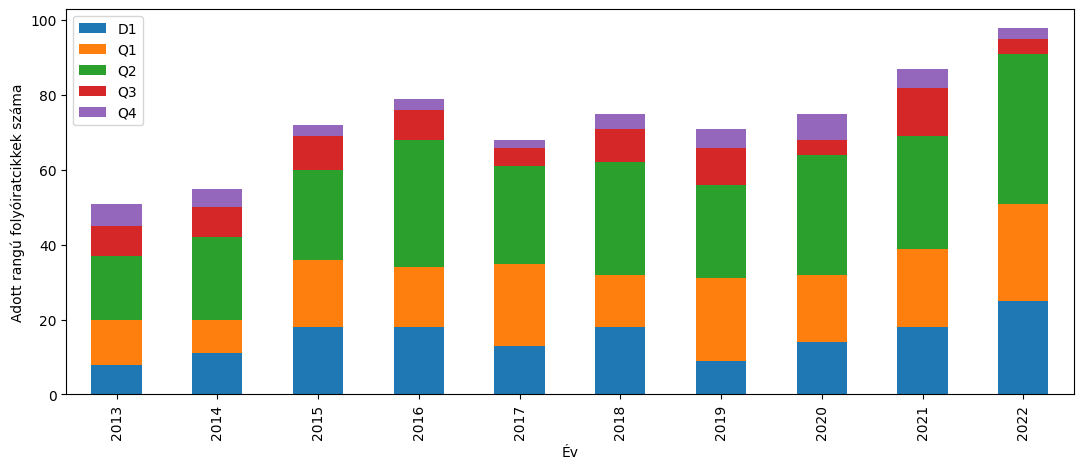

In [9]:
max_year=2023
figSize = (13,5)
df = pubfaculty.reset_index()
df = df.groupby("Év").agg({"D1": "sum", "Q1": "sum", "Q2": "sum", "Q3": "sum", "Q4": "sum"})
df.loc[max_year-10:max_year-1].plot.bar(stacked=True, figsize=figSize, ylabel="Adott rangú folyóiratcikkek száma")


<AxesSubplot: xlabel='Tanszék', ylabel='Adott rangú folyóiratcikkek száma, 2020-2022'>

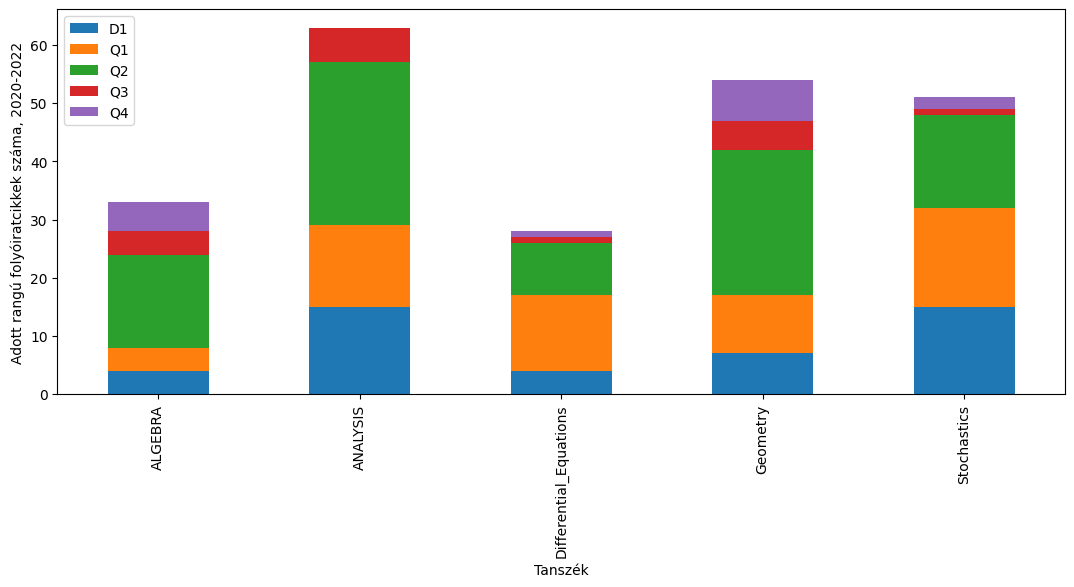

In [10]:
maxYear = max_year-1
minYear = maxYear - 3 + 1
df = pubyearly.reset_index()
df = df[(df["Év"]>=minYear) & (df["Év"]<=maxYear)]
df.groupby("Tanszék").agg({"D1": "sum", "Q1": "sum", "Q2": "sum", "Q3": "sum", "Q4": "sum"}).plot.bar(stacked=True, figsize=figSize, ylabel=f"Adott rangú folyóiratcikkek száma, {minYear}-{maxYear}")

<AxesSubplot: xlabel='Év', ylabel='Adott kategóriájú publikációk száma'>

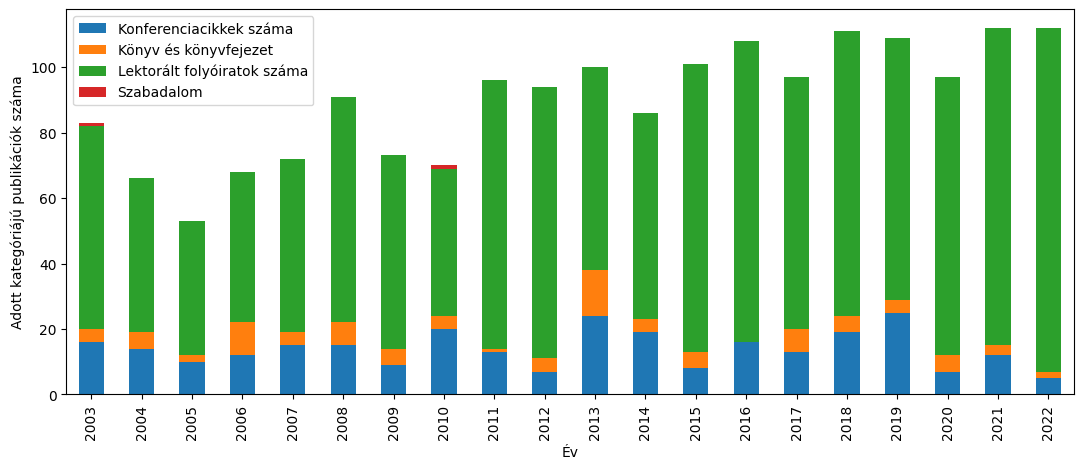

In [11]:
df = pubfaculty.reset_index()
df = df.groupby("Év").agg({"Konferenciacikkek száma": "sum", "Könyv és könyvfejezet": "sum", "Lektorált folyóiratok száma": "sum", "Szabadalom": "sum"})
df.loc[:max_year-1].plot.bar(stacked=True, figsize=figSize, ylabel="Adott kategóriájú publikációk száma")



<AxesSubplot: xlabel='Év', ylabel='Normalizált IF'>

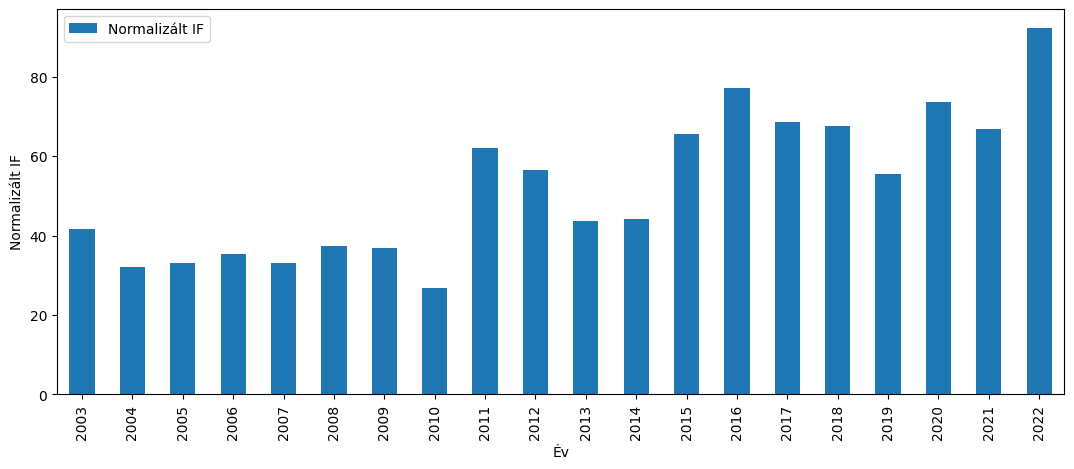

In [12]:
df = pubfaculty.reset_index()
df = df.groupby("Év").agg({"Normalizált IF": "sum"})
df.loc[:max_year-1].plot.bar(stacked=True, figsize=figSize, ylabel="Normalizált IF")

<AxesSubplot: xlabel='Év', ylabel='IF'>

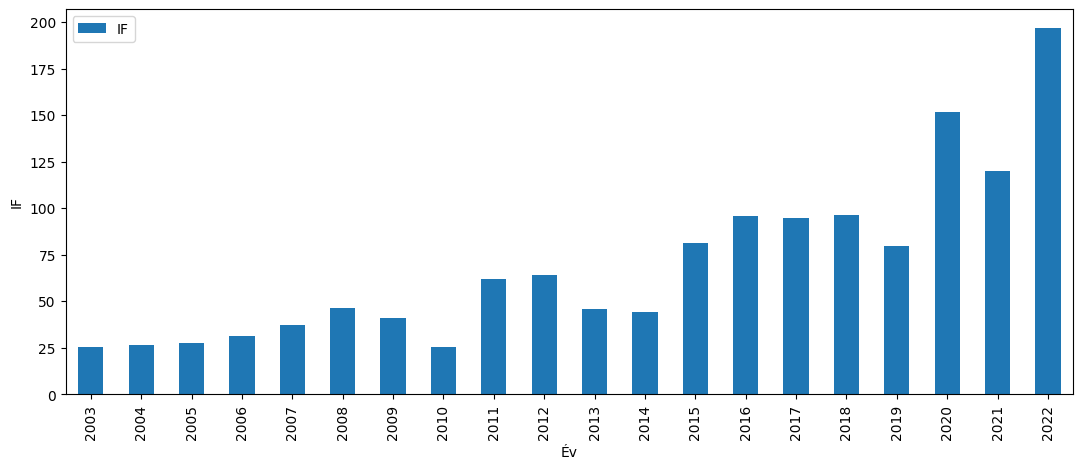

In [13]:
df = pubfaculty.reset_index()
df = df.groupby("Év").agg({"IF": "sum"})
df.loc[:max_year-1].plot.bar(stacked=True, figsize=figSize, ylabel="IF")

<AxesSubplot: xlabel='Év', ylabel='IF-es cikkek száma'>

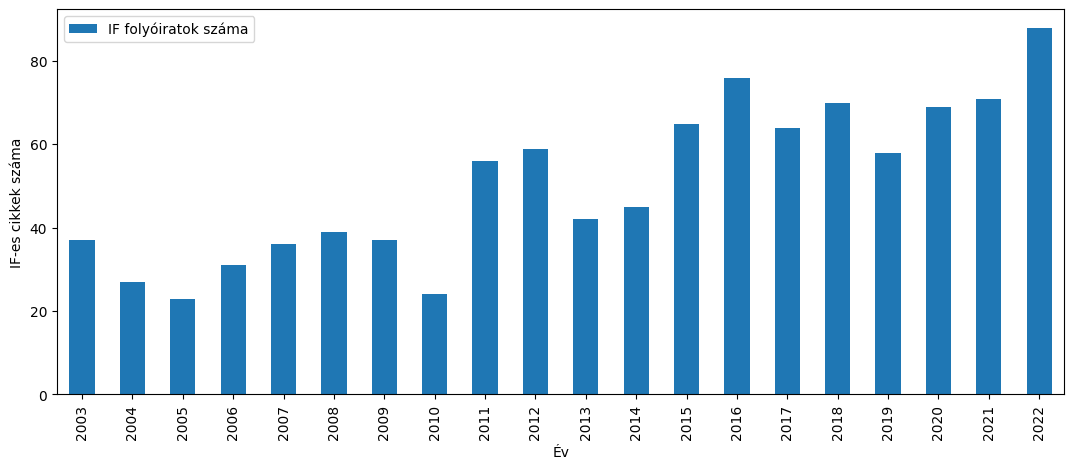

In [14]:
df = pubfaculty.reset_index()
df = df.groupby("Év").agg({"IF folyóiratok száma": "sum"})
df.loc[:max_year-1].plot.bar(stacked=True, figsize=figSize, ylabel="IF-es cikkek száma")

<AxesSubplot: xlabel='Év', ylabel='Idézetek száma'>

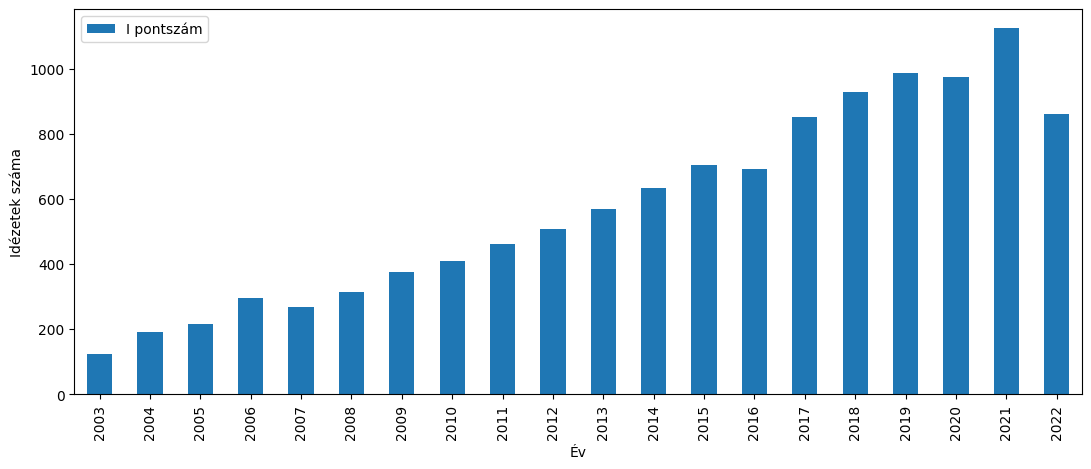

In [15]:
df = pubfaculty.reset_index()
df = df.groupby("Év").agg({"I pontszám": "sum"})
df.loc[:max_year-1].plot.bar(stacked=True, figsize=figSize, ylabel="Idézetek száma")

In [16]:
citations = [(pub["mtmt_i"], pub["mtid"]) for pub in content if pub["publishedYear"]>=2016 and pub["published"]]
len(citations)

887

In [17]:
citations.sort(key=lambda x: x[0])
citations[-10:]

[(30, 3034032),
 (35, 3367962),
 (37, 3100567),
 (37, 30603311),
 (37, 3390170),
 (51, 3327040),
 (52, 3256009),
 (63, 3254496),
 (79, 31312571),
 (101, 3102141)]

In [18]:
citations = [(pub["mtmt_norm_if"], pub["mtid"]) for pub in content if pub["publishedYear"]>=2016 and pub["published"]]
citations.sort(key=lambda x: x[0])
citations[-10:]

[(2.5226620768789445, 32473873),
 (2.6349144634525663, 31312571),
 (2.8498759305210917, 3327040),
 (2.8703308431163284, 32800271),
 (2.8703308431163284, 33030028),
 (3.0541338582677167, 31042545),
 (3.139566395663957, 3254531),
 (3.4609861177596937, 3257464),
 (3.492397660818714, 30603311),
 (4.631257631257632, 3173842)]

In [19]:
citations = [(pub["mtmt_norm_if"], pub["mtid"]) for pub in content]
citations.sort(key=lambda x: x[0])
citations[-10:]

[(3.261146496815287, 1010023),
 (3.37992277992278, 2672544),
 (3.4352861035422344, 2500484),
 (3.4609861177596937, 3257464),
 (3.492397660818714, 30603311),
 (4.3769063180827885, 2614497),
 (4.631257631257632, 3173842),
 (5.001633986928105, 2668429),
 (5.16910569105691, 2633283),
 (6.286415711947627, 2648284)]

In [20]:
citations = [(pub["mtmt_if"], pub["mtid"]) for pub in content]
citations.sort(key=lambda x: x[0])
citations[-10:]

[(6.439, 32828533),
 (6.439, 32711399),
 (6.439, 33031948),
 (6.578, 31794723),
 (6.777, 31312571),
 (7.23, 3257464),
 (7.514, 32855012),
 (8.554, 32865751),
 (10.758, 32800271),
 (10.758, 33030028)]

# Egyéni adatok feldolgozása

In [21]:
staff = pd.read_csv("people_flt.csv")
staff.shape[0]

119

In [22]:
staff_flt = staff[(~staff["MTMT"].isnull()) & (staff["MTMT"]!=11111111) & (staff["MTMT"]!=0) & (staff["Munkakör"].str.lower()!="doktorandusz") & (staff["Munkakör"].str.lower()!="sh doktorandusz")]
staff_flt["MTMT"] = staff_flt["MTMT"].astype("int")
staff_flt.to_csv("people_flt.csv", index=False)
staff_flt.shape[0]

119

In [23]:
def load_pub_for_author(mtid):
    page = 1
    size = 1000
    tries = 1
    author_pubs = []
    while True:
        os.system(f'wget -O tmp.json "https://m2.mtmt.hu/api/publication?cond=published;eq;true&cond=core;eq;true&cond=authors.mtid;eq;{mtid}&sort=publishedYear,desc&sort=firstAuthor,asc&size={size}&fields=citations,pubStats&labelLang=hun&page={page}&format=json" >wget.out 2>wget.err')
        with open("tmp.json", "r") as f:
            try:
                dta = json.load(f)
                if page == 1 and len(dta["content"]) == 0:
                    return []
                author_pubs += dta["content"]
                if not dta["paging"]["last"]:
                    page += 1
                else:
                    break
            except:
                tries += 1
                print("Error, retrying")
                if tries > 30:
                    return []
    return author_pubs

In [24]:
for mtid in tqdm(staff_flt["MTMT"]):
    if not os.path.exists(f"staff/{mtid}.json"):
        json.dump(load_pub_for_author(mtid), open(f"staff/{mtid}.json", "w", encoding='utf8'), indent=4, ensure_ascii=False)

100%|██████████████████████████████████████| 119/119 [00:00<00:00, 69826.83it/s]


In [25]:
def get_h_score(mtid):
    cit_list = []
    if os.path.exists(f'staff/{mtid}.json'):
        with open(f'staff/{mtid}.json') as f:
            try:
                js = json.load(f)
                for pub in js:
                    if "independentCitationCount" in pub:
                        cit_list.append(pub["independentCitationCount"])
            except:
                pass
    cit_list.sort(reverse=True)
    hindex = 0
    while hindex < len(cit_list) and hindex < cit_list[hindex]:
        hindex += 1
    return hindex

In [26]:
staff_flt["H index"] = [0 if np.isnan(mtid) else get_h_score(int(mtid)) for mtid in staff_flt["MTMT"]]

In [27]:
esi_cats = pd.read_csv("esi-master-journal-list-8-2022.csv")
percentiles = pd.read_csv("baselinecitationpercentiles2022.csv")
percentiles.set_index(keys=["category","year"], inplace=True)

def get_esi_category(jour):
    with open(f'journals/{jour}.json') as fj:
        data = json.load(fj)["content"]
        cat = []
        if "abbreviated" in data:
            cat = esi_cats[esi_cats["Title29"]==data["abbreviated"]]["Category name"]
            if len(cat) == 0:
                cat = esi_cats[esi_cats["Title20"]==data["abbreviated"]]["Category name"]
    return cat.iloc[0]
def check_wos(pub):
    if "journal" in pub and "sciIndexed" in pub["journal"] and pub["journal"]["sciIndexed"]:
        return True
    if "identifiers" in pub:
        for i in pub["identifiers"]:
            if i["source"]["label"] == "WoS" or i["source"]["label"] == "Wos-CSCD (Chinese)":
                return True
    return False

In [28]:
for x, a in tqdm(staff_flt.iterrows()):
    if not np.isnan(a["MTMT"]):
        mtid = int(a["MTMT"])
        if os.path.exists(f'staff/{mtid}.json'):
            with open(f'staff/{mtid}.json') as f:
                try:
                    js = json.load(f)
                    for pub in js:      
                        if "journal" in pub and pub["publishedYear"] >= 2012 and check_wos(pub):
                            jour = pub["journal"]["link"].split("/")[-1]
                            if not os.path.exists(f'journals/{jour}.json'):
                                print("Új folyóirat: ", pub["journal"]["label"])
                                os.system(f'wget -O journals/{jour}.json "https://m2.mtmt.hu/api/journal/{jour}"')
                except:
                    pass
        else:
            print("Hiányzó szerző!", mtid)

119it [00:06, 17.12it/s]


In [29]:
journal_categories = {}
for x, a in tqdm(staff_flt.iterrows()):
    if not np.isnan(a["MTMT"]):
        mtid = int(a["MTMT"])
        if os.path.exists(f'staff/{mtid}.json'):
            with open(f'staff/{mtid}.json') as f:
                try:
                    js = json.load(f)
                    for pub in js:      
                        if "journal" in pub and pub["publishedYear"] >= 2012 and check_wos(pub):
                            jour = pub["journal"]["link"].split("/")[-1]
                            journal_categories[jour] = get_esi_category(jour).upper()
                except:
                    pass

119it [00:07, 16.59it/s]


In [30]:
pub_sum = {"tsz": [], "év": [], "szerző": [], "cím": [], "mtmt": [], "idézettség": [], "0.01%": [], "0.10%": [], "1.00%": [], "10.00%": [], "20.00%": [], "50.00%": []}
for x, a in tqdm(staff_flt.iterrows()):
    if not np.isnan(a["MTMT"]):
        mtid = int(a["MTMT"])
        if os.path.exists(f'staff/{mtid}.json'):
            with open(f'staff/{mtid}.json') as f:
                try:
                    js = json.load(f)
                    for pub in js:     
                        if "journal" in pub and "publishedYear" in pub and pub["publishedYear"] >= 2010 and pub["publishedYear"] <= max_year and check_wos(pub):
                            jour = pub["journal"]["link"].split("/")[-1]
                            if jour in journal_categories.keys() and "citationCount" in pub:
                                try:
                                    base = percentiles.loc[(journal_categories[jour], pub["publishedYear"]), :]
                                except KeyError:
                                    print(pub["journal"]["label"], jour, (journal_categories[jour], pub["publishedYear"]))
                                pub_sum["tsz"].append(a["Tanszék"])
                                pub_sum["év"].append(pub["publishedYear"])
                                pub_sum["szerző"].append(a["Név"])
                                pub_sum["cím"].append(pub["title"])
                                pub_sum["idézettség"].append(pub["citationCount"])
                                pub_sum["mtmt"].append(pub["mtid"])
                                r = (pub["citationCount"] >= base).astype(np.int32)
                                pub_sum["0.01%"].append(r["0.01%"])
                                pub_sum["0.10%"].append(r["0.10%"])
                                pub_sum["1.00%"].append(r["1.00%"])
                                pub_sum["10.00%"].append(r["10.00%"])
                                pub_sum["20.00%"].append(r["20.00%"])
                                pub_sum["50.00%"].append(r["50.00%"])
                except:
                    print(sys.exc_info()[0])
                    pass
pubs = pd.DataFrame(pub_sum).drop_duplicates("mtmt")


26it [00:02,  9.11it/s]

APPLIED MATHEMATICS AND COMPUTATION 0096-3003 1873-5649 454 ('MATHEMATICS', 2023)


47it [00:03, 24.86it/s]

PHYSICA A - STATISTICAL MECHANICS AND ITS APPLICATIONS 0378-4371 1873-2119 3674 ('PHYSICS', 2023)
EUROPEAN JOURNAL OF COMBINATORICS 0195-6698 1095-9971 1417130 ('MATHEMATICS', 2023)


119it [00:06, 17.57it/s]

JOURNAL OF THE AMERICAN MATHEMATICAL SOCIETY 0894-0347 1088-6834 13001 ('MATHEMATICS', 2023)


In [31]:
pubs.to_csv("percentille.csv", index=False, float_format='%.4g')

In [32]:
pubs


tsz    év         szerző  \
0         Analízis  2018   Andai Attila   
1         Analízis  2017   Andai Attila   
2         Analízis  2016   Andai Attila   
3    Sztochasztika  2020   Bálint Péter   
4    Sztochasztika  2019   Bálint Péter   
..             ...   ...            ...   
708       Analízis  2013  Weiner Mihály   
709       Analízis  2013  Weiner Mihály   
710       Analízis  2013  Weiner Mihály   
711       Analízis  2012  Weiner Mihály   
712       Analízis  2012  Weiner Mihály   

                                                   cím      mtmt  idézettség  \
0    Volume of the space of qubit-qubit channels an...  30388770           7   
1    Invariance of separability probability over re...   3254502          10   
2    Refinement of Robertson-type uncertainty princ...   3127639           1   
3    Marked Length Spectrum, Homoclinic Orbits and ...  31904067           3   
4    Polynomial Decay of Correlations for Flows, In...  30946012          12   
..                                                 ...       ...         ...   
708  Representations of Conformal Nets, Universal C...   2201427          16   
709  On the snap-back behavior of a self-deploying ...   2520949          16   
710  A gap for the maximum number of mutually unbia...   1888884          30   
711                Thermal States in Conformal QFT. II   2201428          15   
712                Thermal states in conformal QFT, I.   1888900          13   

     0.01%  0.10%  1.00%  10.00%  20.00%  50.00%  
0        0      0      0       0       0       1  
1        0      0      0       0       0       1  
2        0      0      0       0       0       0  
3        0      0      0       0       0       0  
4        0      0      0       0       0       1  
..     ...    ...    ...     ...     ...     ...  
708      0      0      0       0       0       1  
709      0      0      0       0       0       1  
710      0      0      0       1       1       1  
711      0      0      0       0       0       1  
712      0      0      0       0       0       1  

[597 rows x 12 columns]

In [33]:
def score_person(mtid):
    if not os.path.exists(f'staff/{mtid}.json'):
        raise Exception("Nincs letöltve a publikációs lista!")
    pubs = json.load(open(f'staff/{mtid}.json'))
    score = score_publist([mtid], pubs)
    score["mtid"] = int(mtid)
    return score
    
def score_publist(mtid_list, pubs):
    score = {"pub_count": 0, "q_paper": 0, "q_n_paper": 0, "q_book": 0, "if": 0, "relif": 0, "ifcnt": 0, "if_norm": 0, "relif_norm": 0, "h": 0, "i": 0, "first_pub": 2100, "last_pub": 0}
    cit_list = []
    useShare = False
    ix = 0
    for pub in pubs:
        ix += 1
        if "error" in pub and pub["error"]!="VALIDATION_ERROR":
            continue
        if "category" not in pub or pub["category"]["label"]!="Tudományos":
            continue
        # compute share of the authos
        authors = 0
        share = len(mtid_list)/len(pub["authorships"]) if len(pub["authorships"])>0 else 0
        for a in pub["authorships"]:
            if "author" in a and a["author"]["mtid"] in mtid_list and a["authorTyped"]:
                authors += 1
        if authors < len(mtid_list):
            continue
        # compute number of pages
        plength = 0
        try:
            if "pageLength" in pub:
                plength = int(pub["pageLength"])
            elif "firstPage" in pub and "lastPage" in pub:
                plength = int(pub["lastPage"]) - int(pub["firstPage"]) + 1            
        except:
            pass
        # compute impact factor
        ifct, nrm = getif(pub)        
        # compute Q score
        if pub["otype"] == "JournalArticle" and "journal" in pub:
            if "fullPublication" in pub and pub["fullPublication"] and "reviewType" in pub["journal"] and pub["journal"]["reviewType"]=="REVIEWED" and "subType" in pub and \
                pub["subType"]["name"] in ["Szakcikk", "Összefoglaló cikk", "Konferenciaközlemény", "Rövid közlemény", "Sokszerzős vagy csoportos szerzőségű szakcikk"]:                
                if ifct > 0:
                    totalscr = max(0.6,ifct)
                elif "foreignEdition" in pub and pub["foreignEdition"]:
                    totalscr = 0.4
                else:
                    totalscr = 0.3
                score["q_paper"] += totalscr * share
                score["q_n_paper"] += totalscr * share / nrm if nrm > 0 else totalscr * share
                if ifct > 0:
                    score["if"] += ifct
                    score["relif"] += totalscr * share
                    score["ifcnt"] += 1
                    score["if_norm"] += ifct / nrm if nrm > 0 else ifct
                    score["relif_norm"] += totalscr * share / nrm if nrm > 0 else totalscr * share
        elif "fullPublication" in pub and pub["fullPublication"] and \
            ((pub["type"]["label"]=="Könyvrészlet" and "subType" in pub and pub["subType"]["label"]=="Konferenciaközlemény (Könyvrészlet)") or pub["type"]["label"]=="Egyéb konferenciaközlemény"):                
            if plength >= 4:
                totalscr = 0.2 if "foreignLanguage" in pub and pub["foreignLanguage"] else 0.1
                score["q_paper"] += totalscr * share
                score["q_n_paper"] += totalscr * share
        elif pub["type"]["label"] == "Könyv" or \
            (pub["type"]["label"] == "Könyvrészlet" and "subType" in pub and pub["subType"]["label"] in ["Könyvfejezet (Könyvrészlet)", "Szaktanulmány (Könyvrészlet)"]):
            if plength >= 10:
                if plength >= 100:
                    totalscr = 2 if "foreignLanguage" in pub and pub["foreignLanguage"] else 1
                else:
                    totalscr = (0.2 if "foreignLanguage" in pub and pub["foreignLanguage"] else 0.1) * math.floor(plength/10)
                score["q_book"] += totalscr * share
        # Process citations
        if "independentCitationCount" in pub:
            score["i"] += pub["independentCitationCount"]
            cit_list.append(pub["independentCitationCount"])
        if "publishedYear" in pub:
            score["last_pub"] = max(score["last_pub"], pub["publishedYear"])
            score["first_pub"] = min(score["first_pub"], pub["publishedYear"])
        score["pub_count"] += 1
    score["q"] = score["q_paper"] + np.minimum(score["q_book"], 3.0)
    score["qn"] = score["q_n_paper"] + np.minimum(score["q_book"], 3.0)
    # h-index
    cit_list.sort(reverse=True)
    while score["h"] < len(cit_list) and score["h"] < cit_list[score["h"]]:
        score["h"] += 1
        
    return score

In [34]:
dta = {"MTMT": [], "pubCount": [], "qScore": [], "qnScore": [], "ifCount": [], "ifScore": [], "relifScore": [], "ifNormScore": [], "relifNormScore": [], "citations": [], "hIndex": [], "firstPub": [], "lastPub": []}
for idx, prs in staff_flt.iterrows():
    scr = score_person(prs["MTMT"])
    dta["MTMT"].append(scr["mtid"])
    dta["pubCount"].append(scr["pub_count"])
    dta["qScore"].append(scr["q"])
    dta["qnScore"].append(scr["qn"])
    dta["ifCount"].append(scr["ifcnt"])
    dta["ifScore"].append(scr["if"])
    dta["relifScore"].append(scr["relif"])
    dta["ifNormScore"].append(scr["if_norm"])
    dta["relifNormScore"].append(scr["relif_norm"])
    dta["citations"].append(scr["i"])
    dta["hIndex"].append(scr["h"])
    dta["firstPub"].append(scr["first_pub"])
    dta["lastPub"].append(scr["last_pub"])
node_person = pd.DataFrame(dta)
node_person[node_person["pubCount"]>0].to_csv("node_person.csv", index=False, float_format='%.4g')

In [35]:
node_person

MTMT  pubCount     qScore    qnScore  ifCount  ifScore  relifScore  \
0    10012522        23   9.162250   6.800885       10   10.856    8.162250   
1    10041405        36   7.200000  16.093861        6    0.918    2.400000   
2    10011729        33  15.860783  12.435711       26   39.425   15.727450   
3    10042381        15   1.733333   1.733333        0    0.000    0.000000   
4    10011669        31   7.139625   3.533433       10   21.269    5.916898   
..        ...       ...        ...        ...      ...      ...         ...   
114  10019824        20   8.937917   7.132186       15   15.574    8.287917   
115  10019824        20   8.937917   7.132186       15   15.574    8.287917   
116  10042219        39  29.287500  14.404563       30   67.256   29.220833   
117  10015273        33  25.605867  15.803946       30   53.344   25.372533   
118  10009327        23   3.666667   6.102650        2    0.273    0.450000   

     ifNormScore  relifNormScore  citations  hIndex  firstPub  lastPub  
0       7.796477        5.800885         98       7      1998     2020  
1       4.281639       11.293861         42       3      1970     2009  
2      28.957170       12.302377        220       8      1997     2021  
3       0.000000        0.000000          3       1      2008     2017  
4       8.404271        2.310706        168       8      1985     2019  
..           ...             ...        ...     ...       ...      ...  
114    12.140872        6.482186        200       6      2006     2022  
115    12.140872        6.482186        200       6      2006     2022  
116    31.425362       14.337897        144       7      2008     2023  
117    33.254772       15.570612        324      10      2001     2022  
118     1.146168        2.885983        131       5      1983     2004  

[119 rows x 13 columns]

In [36]:
dta = {"source": [], "target": [], "pubCount": [], "qScore": [], "qnScore": [], "ifCount": [], "ifScore": [], "relifScore": [], "ifNormScore": [], "relifNormScore": [], "citations": [], "hIndex": [], "firstPub": [], "lastPub": []}
mtmt_list = list(staff_flt["MTMT"])
publists = {}
for mtmt in mtmt_list:
    publists[mtmt] = json.load(open(f'staff/{mtmt}.json'))
for idx1 in range(0, len(mtmt_list)):
    for idx2 in range(idx1+1, len(mtmt_list)):   
        mtmt1 = mtmt_list[idx1]
        mtmt2 = mtmt_list[idx2]
        pubs1 = publists[mtmt1]
        scr = score_publist([mtmt1, mtmt2], pubs1)
        if scr["pub_count"] > 0:
            dta["source"].append(mtmt1)
            dta["target"].append(mtmt2)
            dta["pubCount"].append(scr["pub_count"])
            dta["qScore"].append(scr["q"])
            dta["qnScore"].append(scr["qn"])
            dta["ifCount"].append(scr["ifcnt"])
            dta["ifScore"].append(scr["if"])
            dta["relifScore"].append(scr["relif"])
            dta["ifNormScore"].append(scr["if_norm"])
            dta["relifNormScore"].append(scr["relif_norm"])
            dta["citations"].append(scr["i"])
            dta["hIndex"].append(scr["h"])
            dta["firstPub"].append(scr["first_pub"])
            dta["lastPub"].append(scr["last_pub"])
relations_person = pd.DataFrame(dta)
node = pd.read_csv('node_person.csv')
result = node[~node['MTMT'].isin(relations_person['source'])]
result = result[~result['MTMT'].isin(relations_person['target'])]
result = result.rename(columns={'MTMT': 'source'})
result['target']="0"
relations_person = pd.concat([relations_person, result], axis=0)
relations_person.to_csv("relations_person.csv", index=False, float_format='%.4g')

In [37]:
pubs=pd.read_csv('people_flt.csv')
relations_person=pd.read_csv('relations_person.csv')
pubs=pubs.rename(columns={"MTMT": "source"})
relations_person=pd.merge(relations_person, pubs[["source", "Név"]], how='inner',  on=["source"])
relations_person=relations_person.drop(['source'], axis=1)
relations_person=relations_person.rename(columns={"Név": "source"})
pubs=pubs.rename(columns={"source": "target"})
relations_person=pd.merge(relations_person, pubs[["target", "Név"]], how='inner',  on=["target"])
relations_person=relations_person.drop(['target'], axis=1)
relations_person=relations_person.rename(columns={"Név": "target"})
relations_person

pubCount  qScore  qnScore  ifCount  ifScore  relifScore  ifNormScore  \
0           9   4.121   2.1500        3    3.821       3.821       1.8500   
1           6   2.038   0.7745        4    8.063       1.888       2.6260   
2           8   3.600  17.7300        4    0.627       2.400       3.5480   
3           1   0.200   0.2000        0    0.000       0.000       0.0000   
4           1   0.200   0.2000        0    0.000       0.000       0.0000   
..        ...     ...      ...      ...      ...         ...          ...   
100         1   1.985   0.5712        1    2.978       1.985       0.8567   
101         2   0.400   0.4000        0    0.000       0.000       0.0000   
102         1   1.430   0.9365        1    1.430       1.430       0.9365   
103         4   1.327   1.2750        1    0.927       0.927       0.8745   
104         2   1.514   1.5870        2    1.502       1.514       1.5730   

     relifNormScore  citations  hIndex  firstPub  lastPub  \
0            1.8500         22       3      2015     2020   
1            0.6245          8       1      2015     2021   
2           16.5300         16       3      1991     2004   
3            0.0000          2       1      1991     1991   
4            0.0000          2       1      1991     1991   
..              ...        ...     ...       ...      ...   
100          0.5712          3       1      2022     2022   
101          0.0000          0       0      2021     2022   
102          0.9365          0       0      2022     2022   
103          0.8745          7       1      2012     2019   
104          1.5870          2       1      2019     2021   

                                 source            target  
0                          Andai Attila      Lovas Attila  
1    Koós Krisztiánné Szilágyi Brigitta      Lovas Attila  
2                      Babcsányi István       Nagy Attila  
3                      Babcsányi István      Wettl Ferenc  
4                           Nagy Attila      Wettl Ferenc  
..                                  ...               ...  
100                       Mosonyi Milán  Szilágyi Zsombor  
101                         Nagy Attila        Tóth Csaba  
102                         Ráth Balázs      Rokob Sándor  
103                        Simon Károly        Vágó Lajos  
104                         Szűcs Zsolt     Takács Balázs  

[105 rows x 14 columns]

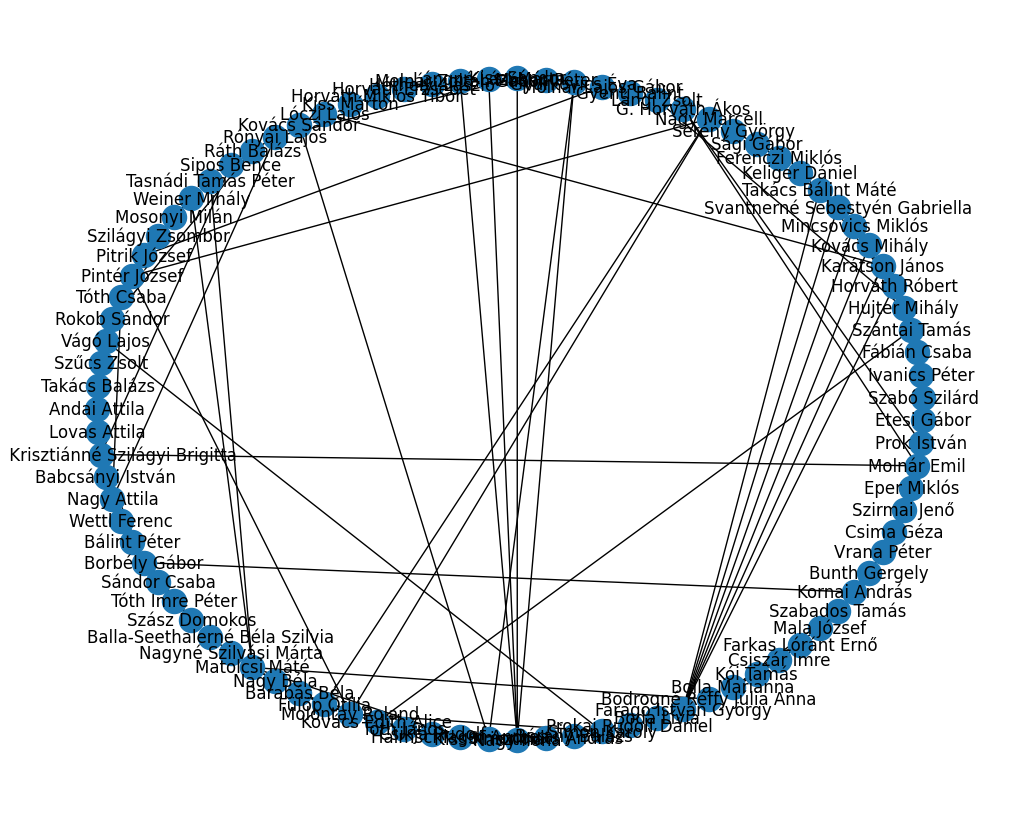

In [38]:
from networkx.algorithms.community import greedy_modularity_communities
import networkx as nx
from matplotlib.pyplot import figure
G = nx.Graph()
G = nx.from_pandas_edgelist(relations_person, "source", "target", ["qScore"])
figure(figsize=(10, 8))
nx.draw_shell(G, with_labels=True)
c = greedy_modularity_communities(G,resolution =1)

The graph has 15 communities.


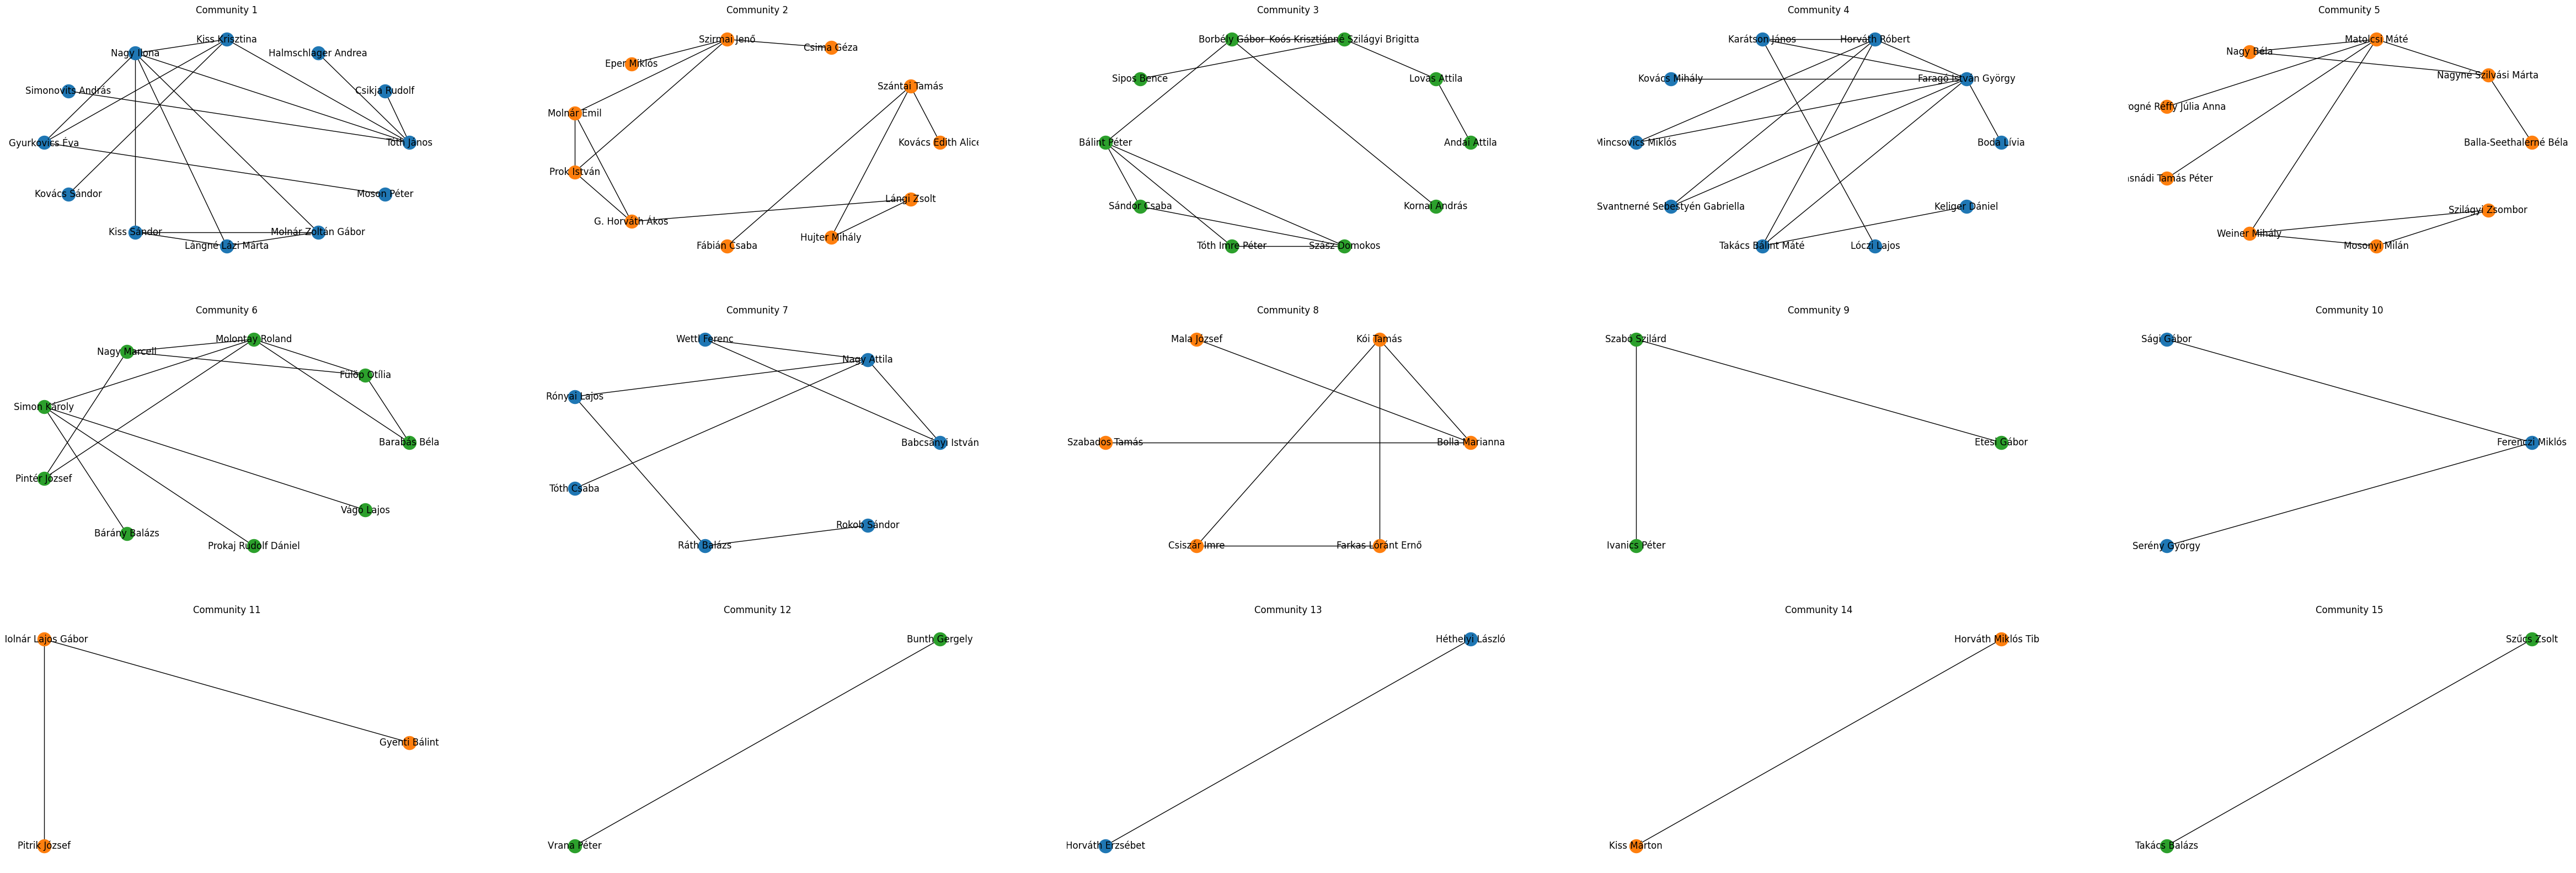

In [39]:
communities = sorted(c, key=len, reverse=True)

print(f"The graph has {len(communities)} communities.")
for c, v_c in enumerate(communities):
    for v in v_c:
        G.nodes[v]['community'] = c + 1

for v, w, in G.edges:
    if G.nodes[v]['community'] == G.nodes[w]['community']:
        G.edges[v, w]['community'] = G.nodes[v]['community']
    else:
        # External edge, mark as 0
        G.edges[v, w]['community'] = 0



N_coms=len(communities)
edges_coms=[]
coms_G=[nx.Graph() for _ in range(N_coms)] #community graphs
colors=['tab:blue','tab:orange','tab:green','tab:blue','tab:orange','tab:green','tab:blue','tab:orange','tab:green','tab:blue','tab:orange','tab:green','tab:blue','tab:orange','tab:green','tab:blue','tab:orange','tab:green']
fig=plt.figure(figsize=(60,20))

for i in range(N_coms):
  edges_coms.append([(u,v,d) for u,v,d in G.edges(data=True) if d['community'] == i+1])#identify edges of interest using the edge attribute
  coms_G[i].add_edges_from(edges_coms[i]) 
  plt.subplot(3,5,i+1)
  plt.title('Community '+str(i+1))
  pos = nx.circular_layout(coms_G[i])
  nx.draw(coms_G[i],pos=pos,with_labels=True,node_color=colors[i]) 

In [40]:
com1=relations_person[relations_person['source'].isin(communities[0])]
com1

pubCount  qScore  qnScore  ifCount  ifScore  relifScore  ifNormScore  \
23         4  0.6667   0.6667        0    0.000       0.000       0.0000   
24         2  0.4000   0.4000        0    0.000       0.000       0.0000   
25         1  0.4000   0.4000        0    0.000       0.000       0.0000   
26         6  4.3560   2.6210        4    5.186       4.276       3.3420   
27         4  1.1000   1.1410        2    0.884       0.800       0.9251   
33         1  0.6610   0.6506        1    0.661       0.661       0.6506   
74         4  9.8120   5.4370        4   13.580       9.812       7.3370   
75         1  0.0000   0.0000        0    0.000       0.000       0.0000   
76         1  1.7880   0.7694        1    3.576       1.788       1.5390   
77         1  1.7880   0.7694        1    3.576       1.788       1.5390   
78         1  0.0000   0.0000        0    0.000       0.000       0.0000   
79         2  0.0000   0.0000        0    0.000       0.000       0.0000   
80         3  0.2000   0.2000        0    0.000       0.000       0.0000   
84         2  2.5480   2.4390        2    3.342       2.548       3.1590   
85         1  0.0000   0.0000        0    0.000       0.000       0.0000   
86         1  0.0000   0.0000        0    0.000       0.000       0.0000   
87         2  0.0000   0.0000        0    0.000       0.000       0.0000   
88         3  2.1330   0.7775        1    4.758       1.903       1.3690   

    relifNormScore  citations  hIndex  firstPub  lastPub               source  \
23          0.0000          0       0      2007     2012        Csikja Rudolf   
24          0.0000          0       0      2004     2004  Halmschlager Andrea   
25          0.0000          1       1      2009     2009       Kiss Krisztina   
26          2.5410         11       2      2009     2020           Nagy Ilona   
27          0.8411          8       2      2007     2012    Simonovits András   
33          0.6506         15       1      2005     2005  Halmschlager Andrea   
74          5.4370         63       3      2017     2020       Gyurkovics Éva   
75          0.0000          0       0      1987     1987       Gyurkovics Éva   
76          0.7694         30       1      2017     2017       Gyurkovics Éva   
77          0.7694         30       1      2017     2017       Kiss Krisztina   
78          0.0000          0       0      2020     2020          Kiss Sándor   
79          0.0000          0       0      2017     2020    Lángné Lázi Márta   
80          0.0000          0       0      2008     2020  Molnár Zoltán Gábor   
84          2.4390         32       2      2008     2009       Kiss Krisztina   
85          0.0000          0       0      2020     2020          Kiss Sándor   
86          0.0000          0       0      2020     2020          Kiss Sándor   
87          0.0000          0       0      2017     2020    Lángné Lázi Márta   
88          0.5475         22       1      2015     2021          Kiss Sándor   

                 target  
23           Tóth János  
24           Tóth János  
25           Tóth János  
26           Tóth János  
27           Tóth János  
33        Matolcsi Máté  
74       Kiss Krisztina  
75          Moson Péter  
76           Nagy Ilona  
77           Nagy Ilona  
78           Nagy Ilona  
79           Nagy Ilona  
80           Nagy Ilona  
84        Kovács Sándor  
85    Lángné Lázi Márta  
86  Molnár Zoltán Gábor  
87  Molnár Zoltán Gábor  
88         Rónyai Lajos

In [41]:
com2=relations_person[relations_person['source'].isin(communities[1])]
com2

pubCount  qScore  qnScore  ifCount  ifScore  relifScore  ifNormScore  \
21         2   2.327   0.6911        1    4.654       2.327       1.3820   
42         9   4.653   4.6920        4    2.955       3.353       2.9150   
43         1   0.600   0.5808        1    0.569       0.600       0.5508   
44        39  11.540  13.2100        6    3.258       3.111       4.4930   
45        19   6.429   7.5820        4    3.218       3.162       4.0700   
49         3   1.228   0.4182        2    3.869       1.228       1.3370   
50         1   0.000   0.0000        0    0.000       0.000       0.0000   
51        18   5.707   4.4020        4    3.902       3.473       2.3600   
67         4   2.609   3.3380        4    2.848       2.609       3.6030   
68         1   0.787   1.2280        1    0.787       0.787       1.2280   
69         1   0.300   0.3000        0    0.000       0.000       0.0000   
71         2   0.800   0.8000        0    0.000       0.000       0.0000   
72        25   5.965   6.8170        3    1.321       1.265       1.8710   

    relifNormScore  citations  hIndex  firstPub  lastPub              source  \
21          0.6911          3       1      2019     2020  Kovács Edith Alice   
42          3.3920         36       4      2010     2019          Csima Géza   
43          0.5808          0       0      2022     2022         Eper Miklós   
44          4.7750         79       4      1995     2022         Molnár Emil   
45          4.3150         41       3      1997     2021         Prok István   
49          0.4182          7       2      2018     2019        Fábián Csaba   
50          0.0000          0       0      2004     2004       Hujter Mihály   
51          2.1690         26       3      2008     2018  Kovács Edith Alice   
67          3.3380         15       2      2014     2022     G. Horváth Ákos   
68          1.2280          3       1      2014     2014       Hujter Mihály   
69          0.0000          8       1      1994     1994     G. Horváth Ákos   
71          0.0000          2       1      2001     2018     G. Horváth Ákos   
72          2.1170         55       4      1988     2021         Molnár Emil   

             target  
21  Molontay Roland  
42     Szirmai Jenő  
43     Szirmai Jenő  
44     Szirmai Jenő  
45     Szirmai Jenő  
49    Szántai Tamás  
50    Szántai Tamás  
51    Szántai Tamás  
67      Lángi Zsolt  
68      Lángi Zsolt  
69      Molnár Emil  
71      Prok István  
72      Prok István

In [42]:
com3=relations_person[relations_person['source'].isin(communities[2])]
com3

pubCount   qScore  qnScore  ifCount  ifScore  relifScore  ifNormScore  \
0          9   4.1210   2.1500        3    3.821       3.821       1.8500   
1          6   2.0380   0.7745        4    8.063       1.888       2.6260   
5          2   1.4590   1.2660        1    2.188       1.459       1.8990   
6         15  11.8500  10.0400       12   16.010      11.850      13.2600   
7         15  11.8500  10.0400       12   16.010      11.850      13.2600   
8         15  11.8500  10.0400       12   16.010      11.850      13.2600   
9         15  11.8500  10.0400       12   16.010      11.850      13.2600   
10         5   2.3890   1.9690        4    4.810       2.255       3.8080   
11         5   2.3890   1.9690        4    4.810       2.255       3.8080   
12         4   2.2550   1.8360        4    4.810       2.255       3.8080   
13         5   2.3890   1.9690        4    4.810       2.255       3.8080   
14         5   2.3890   1.9690        4    4.810       2.255       3.8080   
39         1   0.2667   0.2667        0    0.000       0.000       0.0000   
40         4   0.5000   0.5000        0    0.000       0.000       0.0000   
70         1   0.6000   0.9820        1    0.358       0.600       0.5859   
91         6   0.4533   0.4533        0    0.000       0.000       0.0000   

    relifNormScore  citations  hIndex  firstPub  lastPub  \
0           1.8500         22       3      2015     2020   
1           0.6245          8       1      2015     2021   
5           1.2660          2       1      2011     2012   
6          10.0400         98       6      2002     2021   
7          10.0400         98       6      2002     2021   
8          10.0400         98       6      2002     2021   
9          10.0400         98       6      2002     2021   
10          1.8360         37       3      2002     2018   
11          1.8360         37       3      2002     2018   
12          1.8360         37       3      2002     2018   
13          1.8360         37       3      2002     2018   
14          1.8360         37       3      2002     2018   
39          0.0000          0       0      2016     2016   
40          0.0000          7       2      2016     2019   
70          0.9820         11       1      2011     2011   
91          0.0000          0       0      2019     2022   

                                source                              target  
0                         Andai Attila                        Lovas Attila  
1   Koós Krisztiánné Szilágyi Brigitta                        Lovas Attila  
5                         Bálint Péter                       Borbély Gábor  
6                         Bálint Péter                        Sándor Csaba  
7                         Bálint Péter                     Tóth Imre Péter  
8                         Bálint Péter                        Sándor Csaba  
9                         Bálint Péter                     Tóth Imre Péter  
10                       Szász Domokos                        Sándor Csaba  
11                       Szász Domokos                     Tóth Imre Péter  
12                        Bálint Péter                       Szász Domokos  
13                        Sándor Csaba                       Szász Domokos  
14                     Tóth Imre Péter                       Szász Domokos  
39                       Borbély Gábor  Koós Krisztiánné Szilágyi Brigitta  
40                       Borbély Gábor                       Kornai András  
70  Koós Krisztiánné Szilágyi Brigitta                         Molnár Emil  
91  Koós Krisztiánné Szilágyi Brigitta                         Sipos Bence

In [43]:
com4=relations_person[relations_person['source'].isin(communities[3])]
com4

pubCount   qScore  qnScore  ifCount  ifScore  relifScore  ifNormScore  \
31         2   0.4000   0.4000        0    0.000      0.0000       0.0000   
52        31  22.3200  22.3300       20   26.950     20.4400      25.7500   
53        15  11.3700  13.4600       11   11.560      8.6420      13.3000   
54         3   2.4150   2.1210        3    4.382      2.4150       3.9740   
55         3   1.2000   2.1000        1    0.500      0.6000       1.2500   
56         4   1.1070   1.2230        2    1.277      0.8933       1.4620   
57         1   0.0800   0.0800        0    0.000      0.0000       0.0000   
58         4   1.6080   1.6240        2    2.422      1.6080       2.4240   
59         2   0.5428   0.5337        1    1.357      0.5428       1.3340   
60         5   4.0260   2.9020        3    5.891      3.6790       4.0470   
61         4   3.9460   2.8220        3    5.891      3.6790       4.0470   
62         1   0.9533   0.6243        1    1.430      0.9533       0.9365   
83         1   0.6000   0.9231        1    0.430      0.6000       0.6615   

    relifNormScore  citations  hIndex  firstPub  lastPub  \
31          0.0000          0       0      2021     2022   
52         20.4500        173       8      1999     2022   
53         10.7200        121       6      2001     2019   
54          2.1210          0       0      2017     2019   
55          1.5000          2       1      2000     2003   
56          1.0100          2       1      2012     2022   
57          0.0000          0       0      2018     2018   
58          1.6240         11       3      2015     2018   
59          0.5337          3       1      2016     2017   
60          2.5550          8       2      2016     2022   
61          2.5550          8       2      2016     2022   
62          0.6243          0       0      2022     2022   
83          0.9231         18       1      2005     2005   

                  source                          target  
31            Boda Lívia            Faragó István György  
52  Faragó István György                  Horváth Róbert  
53  Faragó István György                  Karátson János  
54        Horváth Róbert                  Karátson János  
55  Faragó István György                   Kovács Mihály  
56  Faragó István György               Mincsovics Miklós  
57        Horváth Róbert               Mincsovics Miklós  
58  Faragó István György  Svantnerné Sebestyén Gabriella  
59        Horváth Róbert  Svantnerné Sebestyén Gabriella  
60  Faragó István György              Takács Bálint Máté  
61        Horváth Róbert              Takács Bálint Máté  
62        Keliger Dániel              Takács Bálint Máté  
83        Karátson János                     Lóczi Lajos

In [44]:
com5=relations_person[relations_person['source'].isin(communities[4])]
com5

pubCount  qScore  qnScore  ifCount  ifScore  relifScore  ifNormScore  \
15         10  2.4670   2.4670        0    0.000      0.0000       0.0000   
16          2  2.1490   1.9670        1    2.824      1.8830       2.5510   
17          6  3.3170   3.2370        2    3.526      2.3510       3.4060   
32          1  0.7727   0.7704        1    1.159      0.7727       1.1560   
92          5  5.6690   5.4510        3    6.044      5.1030       5.7350   
93          1  0.9700   0.3381        1    1.455      0.9700       0.5071   
94          7  4.8910   4.2990        6    5.813      4.6250       4.8950   
95          1  1.9850   0.5712        1    2.978      1.9850       0.8567   
96          2  2.4300   1.0090        2    3.645      2.4300       1.5130   
100         1  1.9850   0.5712        1    2.978      1.9850       0.8567   

     relifNormScore  citations  hIndex  firstPub  lastPub  \
15           0.0000          0       0      2008     2017   
16           1.7010         19       1      2006     2007   
17           2.2710         19       1      1978     2010   
32           0.7704         15       1      2007     2007   
92           4.8850         61       3      2003     2007   
93           0.3381          1       1      2007     2007   
94           4.0330         63       2      2009     2021   
95           0.5712          3       1      2022     2022   
96           1.0090          3       1      2020     2022   
100          0.5712          3       1      2022     2022   

                             source                 target  
15   Balla-Seethalerné Béla Szilvia  Nagyné Szilvási Márta  
16                    Matolcsi Máté  Nagyné Szilvási Márta  
17                        Nagy Béla  Nagyné Szilvási Márta  
32        Bodrogné Réffy Júlia Anna          Matolcsi Máté  
92                    Matolcsi Máté              Nagy Béla  
93                    Matolcsi Máté    Tasnádi Tamás Péter  
94                    Matolcsi Máté          Weiner Mihály  
95                    Mosonyi Milán          Weiner Mihály  
96                 Szilágyi Zsombor          Weiner Mihály  
100                   Mosonyi Milán       Szilágyi Zsombor

In [45]:
com6=relations_person[relations_person['source'].isin(communities[5])]
com6

pubCount   qScore  qnScore  ifCount  ifScore  relifScore  ifNormScore  \
18          8   7.5410   3.0790        4    9.944      6.8740       3.3710   
19          2   3.3370   1.2260        1    6.140      3.0700       1.9180   
20          2   3.3370   1.2260        1    6.140      3.0700       1.9180   
22          1   0.8393   0.4609        1    1.259      0.8393       0.6914   
28          9   5.8240   5.1360        7    8.887      5.4240       7.7620   
29          2   0.2667   0.2667        0    0.000      0.0000       0.0000   
30          1   1.9340   0.9928        1    1.934      1.9340       0.9928   
65          1   0.3000   0.3000        0    0.000      0.0000       0.0000   
66         18  11.5100   5.7290        4   22.430      9.3480       6.4420   
98          2   0.4681   0.1053        2   13.550      0.4681       2.9850   
99          2   0.4681   0.1053        2   13.550      0.4681       2.9850   
103         4   1.3270   1.2750        1    0.927      0.9270       0.8745   

     relifNormScore  citations  hIndex  firstPub  lastPub  \
18           2.4120         23       2      2012     2019   
19           0.9591          8       1      2017     2019   
20           0.9591          8       1      2017     2019   
22           0.4609         43       1      2010     2010   
28           4.7360         44       3      2012     2022   
29           0.0000          3       1      2018     2019   
30           0.9928          0       0      2022     2022   
65           0.0000          0       0      2021     2021   
66           3.5620         95       5      2018     2022   
98           0.1053          7       2      2022     2022   
99           0.1053          7       2      2022     2022   
103          0.8745          7       1      2012     2019   

                   source           target  
18           Barabás Béla     Fülöp Otília  
19           Barabás Béla  Molontay Roland  
20           Fülöp Otília  Molontay Roland  
22           Barabás Béla       Tóth János  
28          Bárány Balázs     Simon Károly  
29        Molontay Roland     Simon Károly  
30   Prokaj Rudolf Dániel     Simon Károly  
65           Fülöp Otília     Nagy Marcell  
66        Molontay Roland     Nagy Marcell  
98        Molontay Roland    Pintér József  
99           Nagy Marcell    Pintér József  
103          Simon Károly       Vágó Lajos

In [46]:
com7=relations_person[relations_person['source'].isin(communities[6])]
com7

pubCount  qScore  qnScore  ifCount  ifScore  relifScore  ifNormScore  \
2           8  3.6000  17.7300        4    0.627      2.4000       3.5480   
3           1  0.2000   0.2000        0    0.000      0.0000       0.0000   
4           1  0.2000   0.2000        0    0.000      0.0000       0.0000   
89          1  0.4000   0.4000        0    0.000      0.0000       0.0000   
90          1  0.4273   0.5653        1    0.641      0.4273       0.8479   
101         2  0.4000   0.4000        0    0.000      0.0000       0.0000   
102         1  1.4300   0.9365        1    1.430      1.4300       0.9365   

     relifNormScore  citations  hIndex  firstPub  lastPub            source  \
2           16.5300         16       3      1991     2004  Babcsányi István   
3            0.0000          2       1      1991     1991  Babcsányi István   
4            0.0000          2       1      1991     1991       Nagy Attila   
89           0.0000          2       1      2014     2014       Nagy Attila   
90           0.5653         25       1      2006     2006       Ráth Balázs   
101          0.0000          0       0      2021     2022       Nagy Attila   
102          0.9365          0       0      2022     2022       Ráth Balázs   

           target  
2     Nagy Attila  
3    Wettl Ferenc  
4    Wettl Ferenc  
89   Rónyai Lajos  
90   Rónyai Lajos  
101    Tóth Csaba  
102  Rokob Sándor

## the communities search depending on qnScore,ifCount,ifScore,relifScore,ifNormScore,relifNormScore result in same communities as in qScore

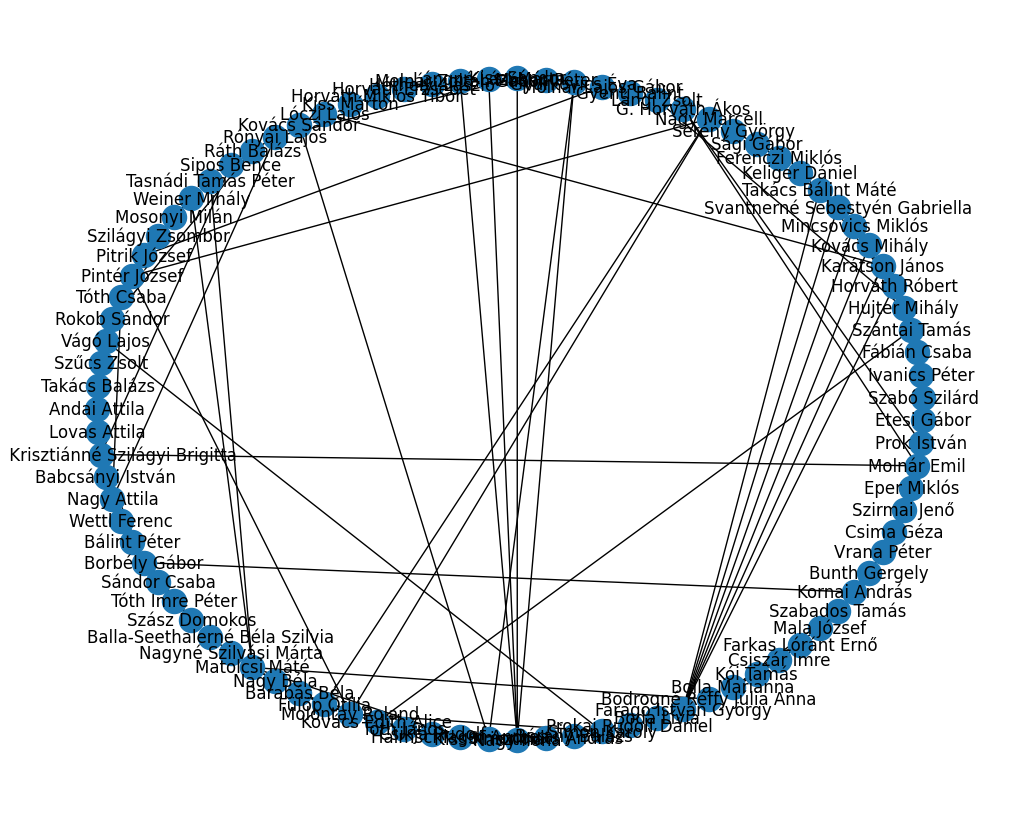

In [47]:
G = nx.Graph()
G = nx.from_pandas_edgelist(relations_person, "source", "target", ["qnScore"])
figure(figsize=(10, 8))
nx.draw_shell(G, with_labels=True)
c = greedy_modularity_communities(G,resolution =1)


The graph has 15 communities.


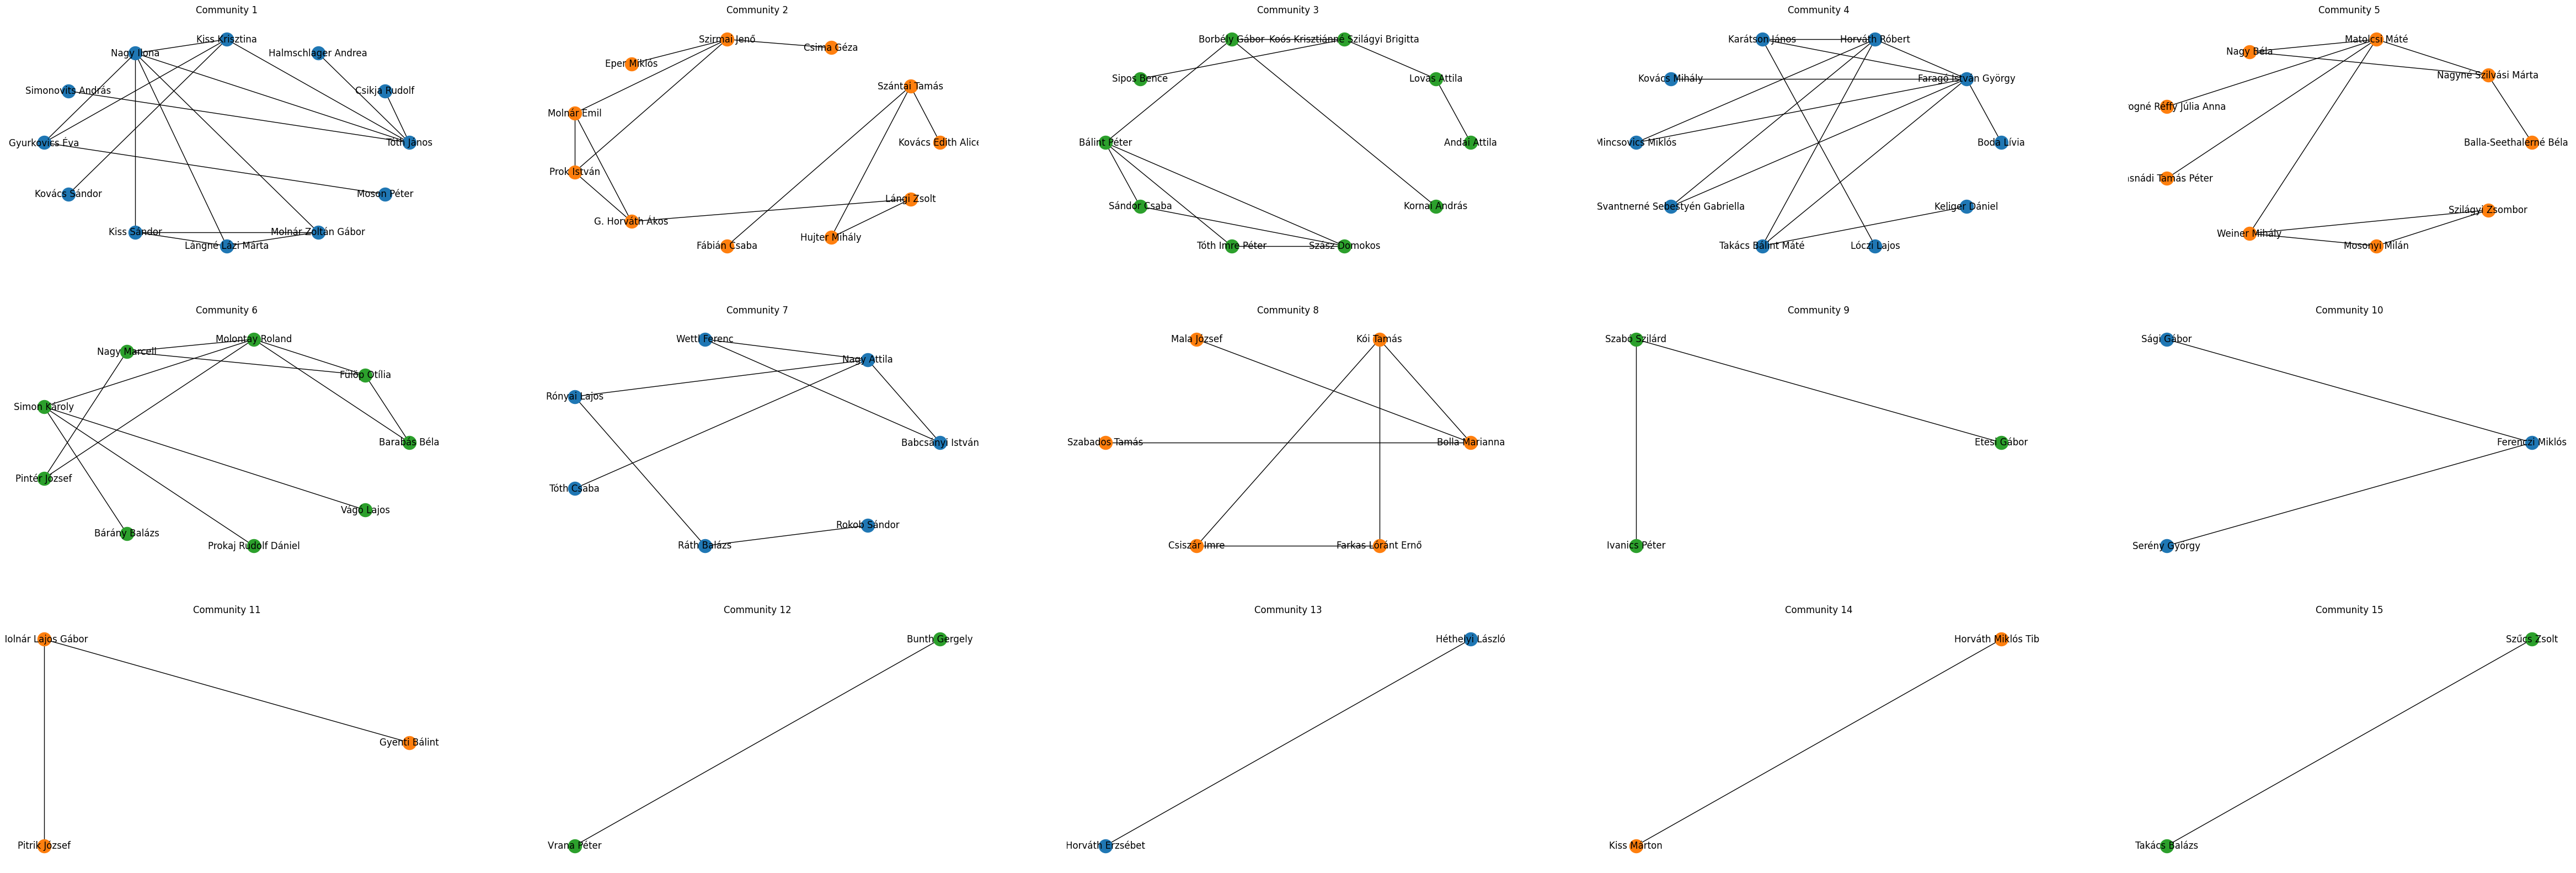

In [48]:
communities = sorted(c, key=len, reverse=True)

print(f"The graph has {len(communities)} communities.")
for c, v_c in enumerate(communities):
    for v in v_c:
        G.nodes[v]['community'] = c + 1

for v, w, in G.edges:
    if G.nodes[v]['community'] == G.nodes[w]['community']:
        G.edges[v, w]['community'] = G.nodes[v]['community']
    else:
        # External edge, mark as 0
        G.edges[v, w]['community'] = 0



N_coms=len(communities)
edges_coms=[]
coms_G=[nx.Graph() for _ in range(N_coms)] #community graphs
colors=['tab:blue','tab:orange','tab:green','tab:blue','tab:orange','tab:green','tab:blue','tab:orange','tab:green','tab:blue','tab:orange','tab:green','tab:blue','tab:orange','tab:green','tab:blue','tab:orange','tab:green']
fig=plt.figure(figsize=(60,20))

for i in range(N_coms):
  edges_coms.append([(u,v,d) for u,v,d in G.edges(data=True) if d['community'] == i+1])#identify edges of interest using the edge attribute
  coms_G[i].add_edges_from(edges_coms[i]) 
  plt.subplot(3,5,i+1)
  plt.title('Community '+str(i+1))
  pos = nx.circular_layout(coms_G[i])
  nx.draw(coms_G[i],pos=pos,with_labels=True,node_color=colors[i]) 

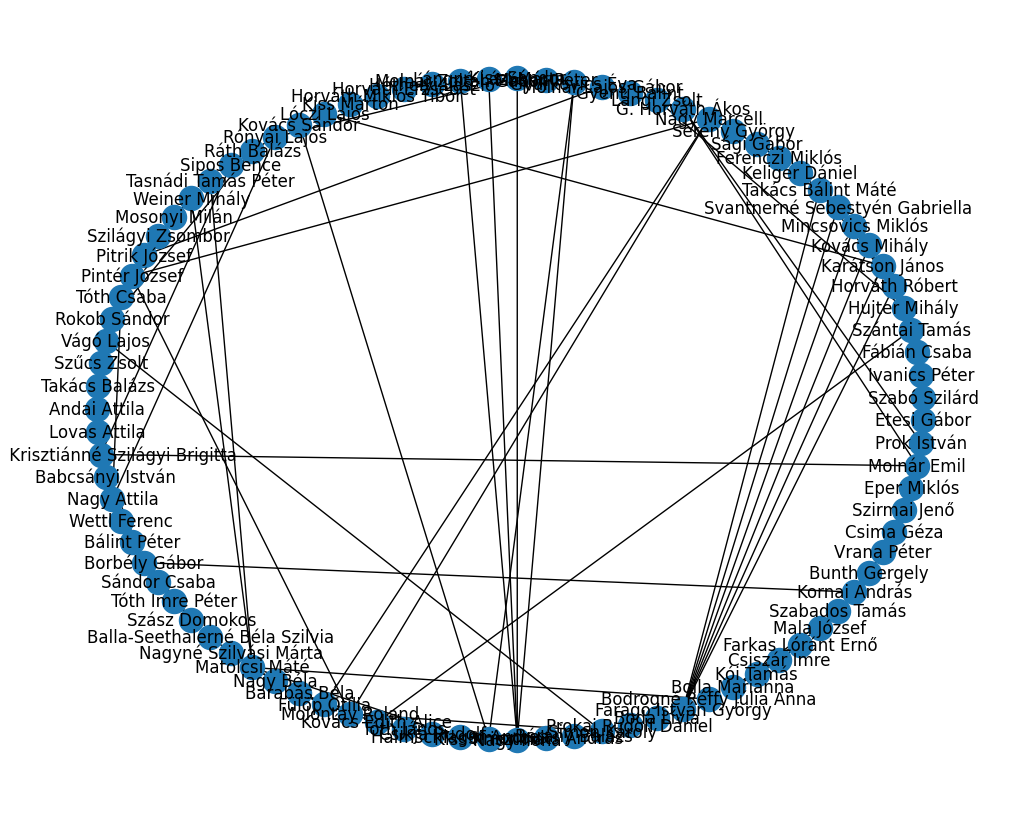

In [49]:
G = nx.Graph()
G = nx.from_pandas_edgelist(relations_person, "source", "target", ["ifScore"])
figure(figsize=(10, 8))
nx.draw_shell(G, with_labels=True)
c = greedy_modularity_communities(G,resolution =1)


The graph has 15 communities.


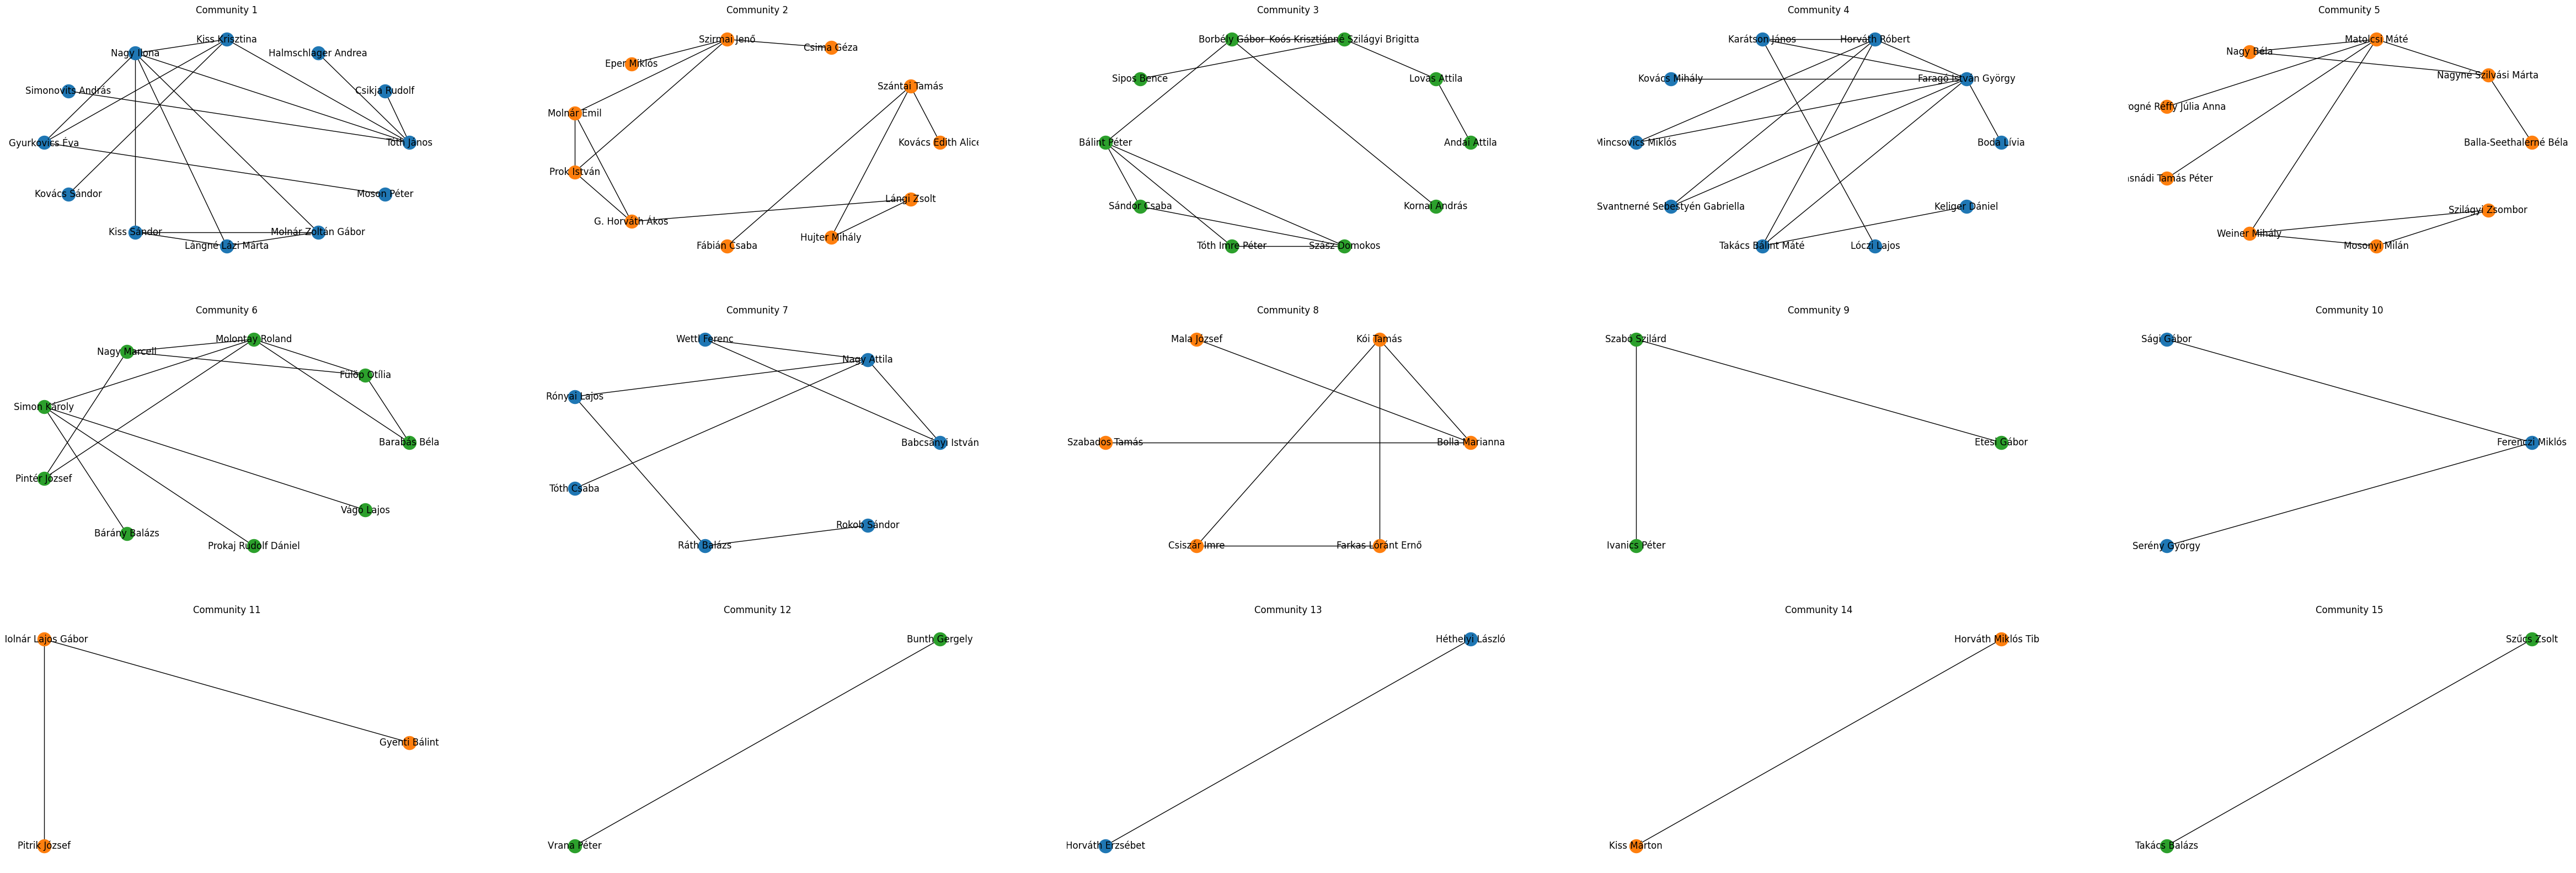

In [50]:
communities = sorted(c, key=len, reverse=True)

print(f"The graph has {len(communities)} communities.")
for c, v_c in enumerate(communities):
    for v in v_c:
        G.nodes[v]['community'] = c + 1

for v, w, in G.edges:
    if G.nodes[v]['community'] == G.nodes[w]['community']:
        G.edges[v, w]['community'] = G.nodes[v]['community']
    else:
        # External edge, mark as 0
        G.edges[v, w]['community'] = 0



N_coms=len(communities)
edges_coms=[]
coms_G=[nx.Graph() for _ in range(N_coms)] #community graphs
colors=['tab:blue','tab:orange','tab:green','tab:blue','tab:orange','tab:green','tab:blue','tab:orange','tab:green','tab:blue','tab:orange','tab:green','tab:blue','tab:orange','tab:green','tab:blue','tab:orange','tab:green']
fig=plt.figure(figsize=(60,20))

for i in range(N_coms):
  edges_coms.append([(u,v,d) for u,v,d in G.edges(data=True) if d['community'] == i+1])#identify edges of interest using the edge attribute
  coms_G[i].add_edges_from(edges_coms[i]) 
  plt.subplot(3,5,i+1)
  plt.title('Community '+str(i+1))
  pos = nx.circular_layout(coms_G[i])
  nx.draw(coms_G[i],pos=pos,with_labels=True,node_color=colors[i]) 

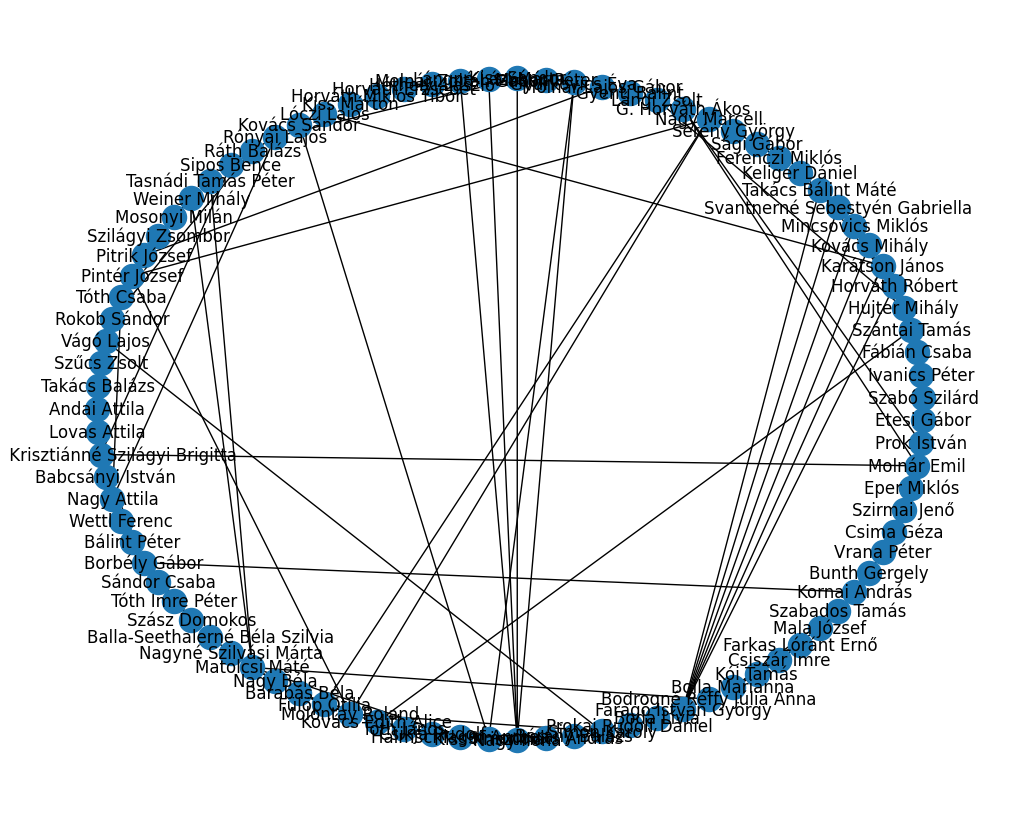

In [51]:
G = nx.Graph()
G = nx.from_pandas_edgelist(relations_person, "source", "target", ["relifScore"])
figure(figsize=(10, 8))
nx.draw_shell(G, with_labels=True)
c = greedy_modularity_communities(G,resolution =1)

The graph has 15 communities.


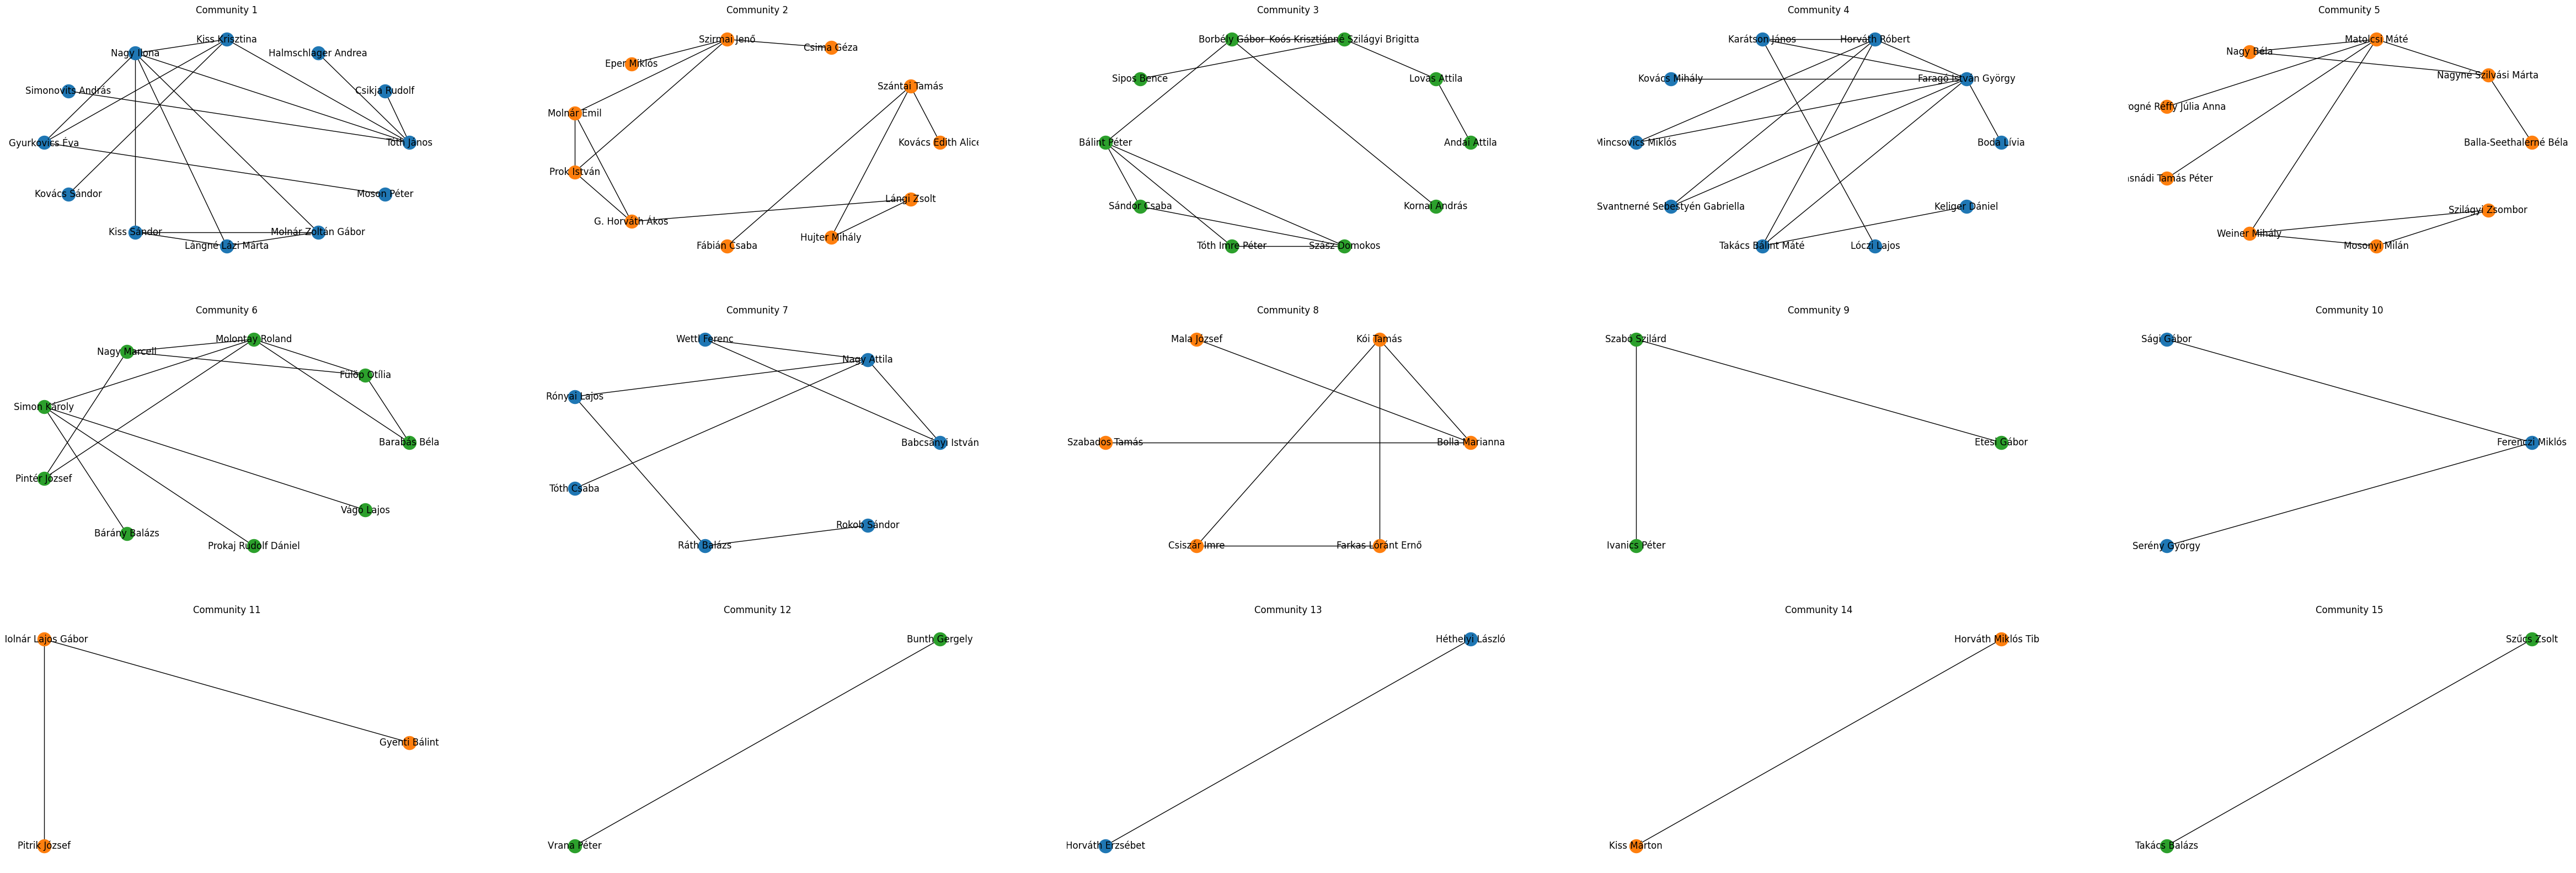

In [52]:
communities = sorted(c, key=len, reverse=True)

print(f"The graph has {len(communities)} communities.")
for c, v_c in enumerate(communities):
    for v in v_c:
        G.nodes[v]['community'] = c + 1

for v, w, in G.edges:
    if G.nodes[v]['community'] == G.nodes[w]['community']:
        G.edges[v, w]['community'] = G.nodes[v]['community']
    else:
        # External edge, mark as 0
        G.edges[v, w]['community'] = 0



N_coms=len(communities)
edges_coms=[]
coms_G=[nx.Graph() for _ in range(N_coms)] #community graphs
colors=['tab:blue','tab:orange','tab:green','tab:blue','tab:orange','tab:green','tab:blue','tab:orange','tab:green','tab:blue','tab:orange','tab:green','tab:blue','tab:orange','tab:green','tab:blue','tab:orange','tab:green']
fig=plt.figure(figsize=(60,20))

for i in range(N_coms):
  edges_coms.append([(u,v,d) for u,v,d in G.edges(data=True) if d['community'] == i+1])#identify edges of interest using the edge attribute
  coms_G[i].add_edges_from(edges_coms[i]) 
  plt.subplot(3,5,i+1)
  plt.title('Community '+str(i+1))
  pos = nx.circular_layout(coms_G[i])
  nx.draw(coms_G[i],pos=pos,with_labels=True,node_color=colors[i]) 

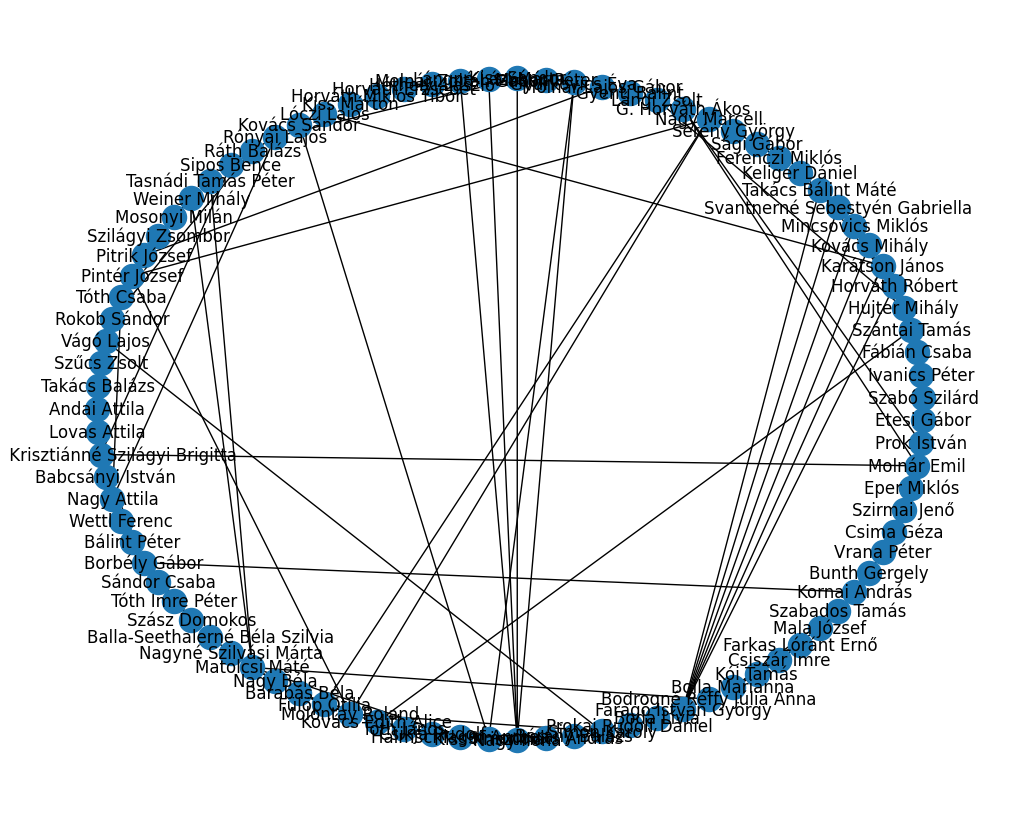

In [53]:
G = nx.Graph()
G = nx.from_pandas_edgelist(relations_person, "source", "target", ["ifNormScore"])
figure(figsize=(10, 8))
nx.draw_shell(G, with_labels=True)
c = greedy_modularity_communities(G,resolution =1)

The graph has 15 communities.


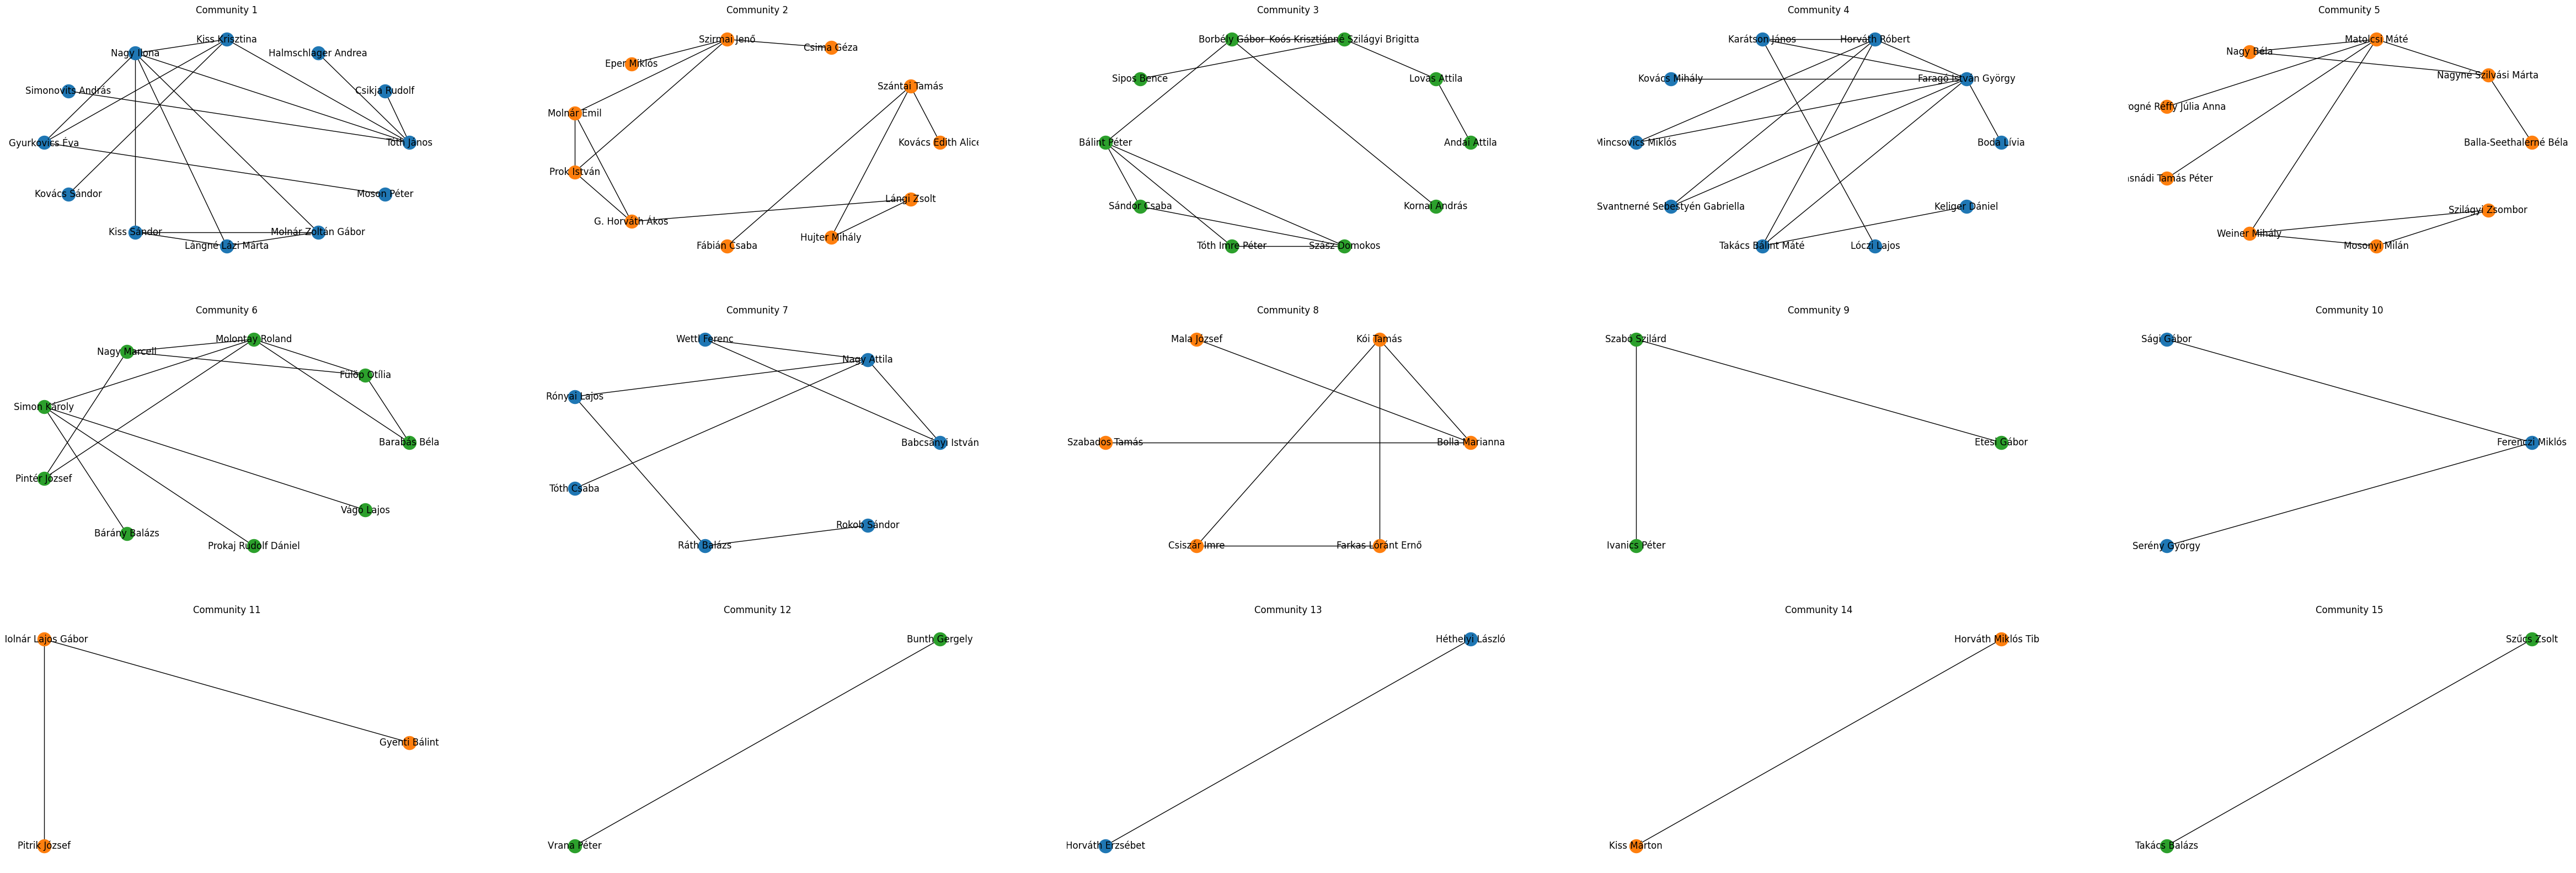

In [54]:
communities = sorted(c, key=len, reverse=True)

print(f"The graph has {len(communities)} communities.")
for c, v_c in enumerate(communities):
    for v in v_c:
        G.nodes[v]['community'] = c + 1

for v, w, in G.edges:
    if G.nodes[v]['community'] == G.nodes[w]['community']:
        G.edges[v, w]['community'] = G.nodes[v]['community']
    else:
        # External edge, mark as 0
        G.edges[v, w]['community'] = 0



N_coms=len(communities)
edges_coms=[]
coms_G=[nx.Graph() for _ in range(N_coms)] #community graphs
colors=['tab:blue','tab:orange','tab:green','tab:blue','tab:orange','tab:green','tab:blue','tab:orange','tab:green','tab:blue','tab:orange','tab:green','tab:blue','tab:orange','tab:green','tab:blue','tab:orange','tab:green']
fig=plt.figure(figsize=(60,20))

for i in range(N_coms):
  edges_coms.append([(u,v,d) for u,v,d in G.edges(data=True) if d['community'] == i+1])#identify edges of interest using the edge attribute
  coms_G[i].add_edges_from(edges_coms[i]) 
  plt.subplot(3,5,i+1)
  plt.title('Community '+str(i+1))
  pos = nx.circular_layout(coms_G[i])
  nx.draw(coms_G[i],pos=pos,with_labels=True,node_color=colors[i]) 